In [1]:
# Load Required Libraries
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from functools import reduce
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,10)
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')


#### Load Data

In [2]:
#Load Calendar Data
calendar = pd.read_csv('./data/calendar.csv')
calendar.head(2)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


In [3]:
#Load Listings Data
listings = pd.read_csv('./data/listings.csv')
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [4]:
#Load Reviews Data
reviews = pd.read_csv('./data/reviews.csv')
reviews.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...


In [5]:
print('The Seattle Airbnb data has {} listings, which were rented out by {} hosts.'.
      format(listings.shape[0], listings.host_id.nunique()))
print('The Seattle Airbnb data has {} reviews, provided from {} to {}.'.
      format(reviews.shape[0], reviews.date.min(), reviews.date.max()))
print('The availability data for Seattle Airbnb has been provided from {} to {} on {} homes.'.
      format(calendar.date.min(), calendar.date.max(), calendar.listing_id.nunique()))

The Seattle Airbnb data has 3818 listings, which were rented out by 2751 hosts.
The Seattle Airbnb data has 84849 reviews, provided from 2009-06-07 to 2016-01-03.
The availability data for Seattle Airbnb has been provided from 2016-01-04 to 2017-01-02 on 3818 homes.


## Clean and Transform Data

### Transform Data

#### Rename ID and Price Columns to esnure unique column names across all 3 data frames

In [6]:
listings = listings.rename(columns={'id': 'listing_id'})
reviews = reviews.rename(columns={'id': 'review_id'})
calendar = calendar.rename(columns={'price': 'price_2'})

#### Transform Date Fields

In [7]:
### Function to Convert Currency Columns to Float
listings['host_since'] = pd.to_datetime(listings['host_since'])
listings['first_review'] = pd.to_datetime(listings['first_review'])
listings['last_review'] = pd.to_datetime(listings['last_review'])

reviews["date"]= pd.to_datetime(reviews["date"])
calendar["date"]= pd.to_datetime(calendar["date"]) 


In [8]:
# Create Additonal Date Fields 
def create_date_fields(df):
    date_columns = list(df.select_dtypes(include = ["datetime"]).columns)
    for col in date_columns:
        if len(date_columns) >1:
            prefix = col+'_'
        else:
            prefix = ''
        df[prefix+"day"] = df[col].dt.day.astype('Int64')
        df[prefix+"day_name"] = df[col].dt.day_name()
        df[prefix+"dayofweek"] = df[col].dt.dayofweek.astype('Int64')
        df[prefix+"IsWeekend"] = df[prefix+"dayofweek"]  >= 5
        df[prefix+"month"] = df[col].dt.month.astype('Int64')
        df[prefix+"month_name"] = df[col].dt.month_name()
        df[prefix+"month_year"] = df[col].dt.to_period("M")
        df[prefix+"quarter"] = df[col].dt.quarter.astype('Int64')
        df[prefix+"quarter_year"] = df[col].dt.to_period("Q")
        df[prefix+"year"] = df[col].dt.year.astype('Int64')
    return df

In [9]:
reviews = create_date_fields(reviews)
reviews.head(2)

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,day,day_name,dayofweek,IsWeekend,month,month_name,month_year,quarter,quarter_year,year
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,19,Sunday,6,True,7,July,2015-07,3,2015Q3,2015
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,20,Monday,0,False,7,July,2015-07,3,2015Q3,2015


In [10]:
listings = create_date_fields(listings)
listings.head(2)

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,last_review_day,last_review_day_name,last_review_dayofweek,last_review_IsWeekend,last_review_month,last_review_month_name,last_review_month_year,last_review_quarter,last_review_quarter_year,last_review_year
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,2,Saturday,5,True,1,January,2016-01,1,2016Q1,2016
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,29,Tuesday,1,False,12,December,2015-12,4,2015Q4,2015


In [11]:
calendar = create_date_fields(calendar)
calendar.head(2)

,listing_id,date,available,price_2,day,day_name,dayofweek,IsWeekend,month,month_name,month_year,quarter,quarter_year,year
0,241032,2016-01-04,t,$85.00,4,Monday,0,False,1,January,2016-01,1,2016Q1,2016
1,241032,2016-01-05,t,$85.00,5,Tuesday,1,False,1,January,2016-01,1,2016Q1,2016


#### Drop Columns which has more than 80% mssing values

In [12]:
def clean_missing_data(df,threshold_column=80):
    """Method to clean the misisng value in dataframe
    
    INPUT:
        df (Dataframe) : input dataframe to be cleaned
        threshold_column (float) : Threshold for fraction of data to be missing
    
    OUTPUT:
        df (dataframe): cleaned data frame
    """
    #dropping columns which has more than 80% missing values
    missing_columns = [col for col in df.columns if df[col].isnull().any()]
    pct_null= df[missing_columns].isna().sum()*100/df.shape[0]
    missing_features = pct_null[pct_null > threshold_column].index
    df.drop(missing_features, axis=1, inplace=True)
    if len(missing_features) > 0:   
        print('# Columns having more than %s percent missing values: :'%(threshold_column),len(missing_features))
        print("Columns:\n",list(set(missing_features)))
    else:
        print('# Columns having more than %s percent missing values: :'%(threshold_column),len(missing_features))
    return df

In [13]:
listings_clean = clean_missing_data(listings)


# Columns having more than 80 percent missing values: : 2
Columns:
 ['square_feet', 'license']


In [14]:
calendar_clean = clean_missing_data(calendar)

# Columns having more than 80 percent missing values: : 0


In [15]:
reviews_clean = clean_missing_data(reviews)

# Columns having more than 80 percent missing values: : 0


#### Convert Currency Columns to Float

In [16]:
### Function to Convert Currency Columns to Float
def clean_currency_fields(df,columns_to_clean):
    '''
    INPUT 
        df - a dataframe holding the currency columns   
        columns_to_clean - list of columns containing currency values
    OUTPUT
        new_df - a dataframe containing float values of currency columns
    '''
    df[columns_to_clean] = df[columns_to_clean].replace('[\$,]', '', regex=True).astype(float)
    return df
        

In [17]:
calendar_clean = clean_currency_fields(calendar_clean,'price_2')
calendar_clean.head(2)

,listing_id,date,available,price_2,day,day_name,dayofweek,IsWeekend,month,month_name,month_year,quarter,quarter_year,year
0,241032,2016-01-04,t,85.0,4,Monday,0,False,1,January,2016-01,1,2016Q1,2016
1,241032,2016-01-05,t,85.0,5,Tuesday,1,False,1,January,2016-01,1,2016Q1,2016


In [18]:
listing_currency_columns = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee']
listings_clean = clean_currency_fields(listings_clean,listing_currency_columns)
listings_clean[listing_currency_columns].head(2)

,price,weekly_price,monthly_price,security_deposit,cleaning_fee
0,85.0,NaN,NaN,NaN,NaN
1,150.0,1000.0,3000.0,100.0,40.0


In [19]:
# dropping columns not relevant to analysis
column_to_drop = ["listing_url","scrape_id","last_scraped","thumbnail_url","medium_url","picture_url","xl_picture_url","host_url","neighborhood_overview", "notes", "transit","host_thumbnail_url",
                   "host_location","host_picture_url","calendar_last_scraped"]
listings_clean = listings_clean.drop(column_to_drop, axis=1)

#### Amenities

In [20]:
#Clean Amenties Column - Indetify Top 10 Amenties offered in seattle
listings.amenities.head()

0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object

In [21]:
unique_amenities=['Other pet(s)',
 'ShampooAir Conditioning',
 'KitchenInternet',
 'Kitchen',
 'Elevator in Building',
 'IronWireless Internet',
 'Family/Kid Friendly',
 'Internet',
 'EssentialsKitchen',
 'Fire Extinguisher',
 'KitchenTV',
 'Wheelchair Accessible',
 'Hair Dryer',
 'DryerTV',
 'Family/Kid FriendlyTV',
 'HeatingInternet',
 'Pets Allowed',
 'Carbon Monoxide DetectorTV',
 'Safety Card',
 'TV',
 'ShampooWireless Internet',
 'Iron',
 'HeatingWireless Internet',
 'Lock on Bedroom DoorCable TV',
 'DryerInternet',
 'Hot Tub',
 'Lock on Bedroom DoorTV',
 'EssentialsCable TV',
 'Wireless InternetWireless Internet',
 'EssentialsTV',
 'HeatingCable TV',
 'IronTV',
 'Smoke DetectorCable TV',
 'Carbon Monoxide DetectorInternet',
 'Fire ExtinguisherWireless Internet',
 'ShampooElevator in Building',
 'ShampooSmoke Detector',
 'ShampooInternet',
 'Free Parking on Premises',
 'ShampooPool',
 '24-Hour Check-inKitchen',
 'Hair DryerInternet',
 'HangersWireless Internet',
 'HangersTV',
 'ShampooKitchenTV',
 'ShampooKitchen',
 'Cable TV',
 '24-Hour Check-inWireless Internet',
 'Buzzer/Wireless Intercom',
 'Hair DryerTV',
 'Smoke DetectorInternet',
 'Laptop Friendly WorkspaceCable TV',
 '24-Hour Check-inTV',
 'EssentialsInternet',
 'First Aid KitInternet',
 'Suitable for Events',
 'ShampooTV',
 'Lock on Bedroom DoorInternet',
 'Hangers',
 'IronInternet',
 'DryerKitchen',
 'Elevator in BuildingTV',
 'First Aid KitWireless Internet',
 'Carbon Monoxide DetectorWireless Internet',
 'Laptop Friendly WorkspaceInternet',
 'Smoke DetectorTV',
 'Pool',
 'Doorman',
 'Suitable for EventsTV',
 'EssentialsFree Parking on Premises',
 'Carbon Monoxide Detector',
 'EssentialsWireless Internet',
 '24-Hour Check-in',
 'Laptop Friendly WorkspaceWireless Internet',
 'Dryer',
 'Hair DryerCable TV',
 'WasherInternet',
 'Washer / Dryer',
 'Lock on Bedroom DoorWireless Internet',
 'HeatingTV',
 'Safety CardCable TV',
 'Smoking Allowed',
 'HangersInternet',
 'Cat(s)',
 'DryerWireless Internet',
 'Indoor Fireplace',
 'Lock on Bedroom DoorKitchen',
 'Indoor FireplaceTV',
 'Gym',
 'Smoke Detector',
 'Safety CardTV',
 'Air Conditioning',
 'Laptop Friendly WorkspaceTV',
 'Hair DryerWireless Internet',
 'Laptop Friendly Workspace',
 'Dog(s)',
 'Smoke DetectorWireless Internet',
 'Lock on Bedroom Door',
 'Breakfast',
 'DryerCable TV',
 'ShampooWheelchair Accessible',
 'ShampooCable TV',
 'Fire ExtinguisherKitchen',
 'Laptop Friendly WorkspaceKitchen',
 'IronCable TV',
 'Family/Kid FriendlyInternet',
 'Wireless Internet',
 'First Aid Kit',
 'Essentials',
 'Heating',
 'Shampoo',
 'Fire ExtinguisherInternet',
 '24-Hour Check-inInternet',
 'Wireless InternetTV',
 'Fire ExtinguisherCable TV',
 'Washer',
 'First Aid KitTV',
 'Fire ExtinguisherTV',
 'Pets live on this property',
 'Family/Kid FriendlyWireless Internet']

In [22]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [23]:
def clean_and_plot(df, column,look_for, title='Amenities offered in Seattle', plot=True):
    '''
    INPUT 
        df - a dataframe holding the concaneted column 
        column - the column name you want to look through
        look_for - a list of strings you want to search for in each row of df[col]
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        new_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    new = df[column].value_counts().reset_index()
    new.rename(columns={'index': 'Amenities', column: 'count'}, inplace=True)
    new_df = total_count(new, 'Amenities', 'count', look_for)

    new_df.set_index('Amenities', inplace=True)
    if plot:
        # Plotting a figure of width 10 and height 5
        fig = plt.figure()

        fig.set_size_inches(10, 5)
        (new_df/new_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_new_df = new_df/new_df.sum()
    return props_new_df
    

<Figure size 720x360 with 0 Axes>

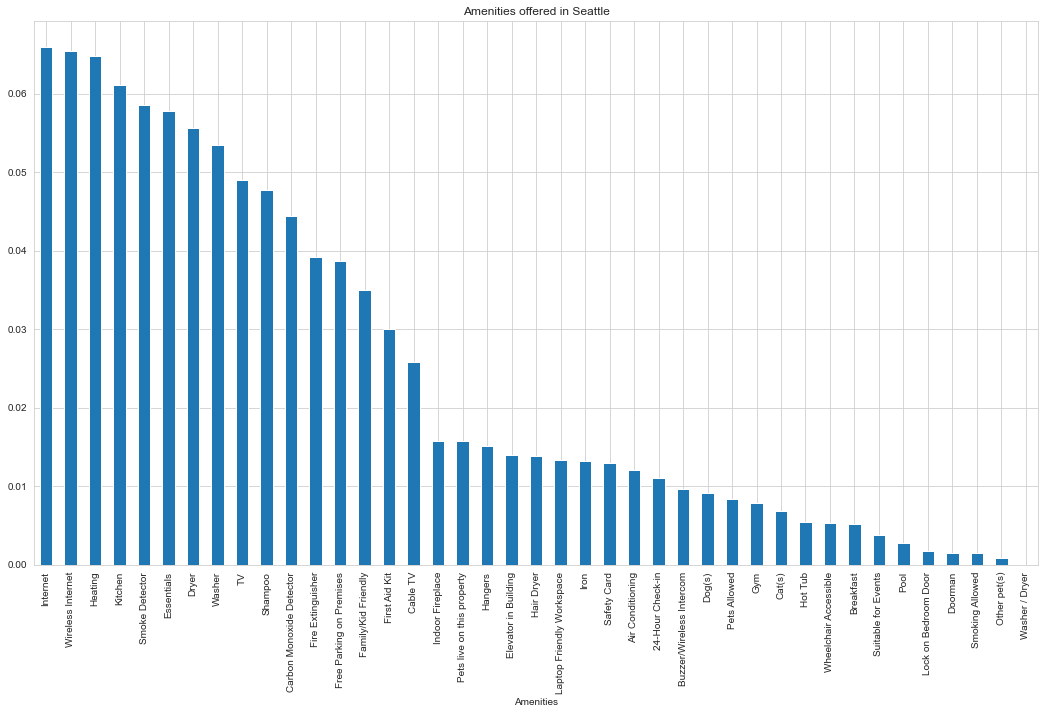

In [24]:
props_df = clean_and_plot(listings_clean,'amenities',unique_amenities);

In [25]:
for i in range(len(listings_clean)):
    if 'Internet' in listings_clean.loc[i,'amenities'] :
        listings_clean.loc[i,'Internet'] = 1
    else :
        listings_clean.loc[i,'Internet'] = 0
    
    if 'Heating' in listings_clean.loc[i,'amenities'] :
        listings_clean.loc[i,'Heating'] = 1
    else :
        listings_clean.loc[i,'Heating'] = 0
    
    if 'Kitchen' in listings_clean.loc[i,'amenities']:
        listings_clean.loc[i,'Kitchen'] = 1 
    else :
        listings_clean.loc[i,'Kitchen'] = 0
    if ('"Smoke Detector"' in listings_clean.loc[i,'amenities']) or ('"Carbon Monoxide Detector"' in listings_clean.loc[i,'amenities']):
        listings_clean.loc[i,'Gas_detector'] = 1
    else :
        listings_clean.loc[i,'Gas_detector'] = 0
    
    if 'Essentials' in listings_clean.loc[i,'amenities']:
        listings_clean.loc[i,'Essentials'] = 1
    else :
        listings_clean.loc[i,'Essentials'] = 0
        
    if ('Dryer' in listings_clean.loc[i,'amenities']) or ('Washer' in listings_clean.loc[i,'amenities']):
        listings_clean.loc[i,'Washer_dryer'] = 1
    else :
        listings_clean.loc[i,'Washer_dryer'] = 0
        
    if 'TV' in listings_clean.loc[i,'amenities']:
        listings_clean.loc[i,'TV'] = 1
    else :
        listings_clean.loc[i,'TV'] = 0
        
    if '"Air Conditioning"' in listings_clean.loc[i,'amenities']:
        listings_clean.loc[i,'AC'] = 1
    else :
        listings_clean.loc[i,'AC'] = 0
        
    if '"Free Parking on Premises"' in listings_clean.loc[i,'amenities']:
        listings_clean.loc[i,'Free_parking'] = 1
    else :
        listings_clean.loc[i,'Free_parking'] = 0
        

    
listings_clean.sample(2)

,listing_id,name,summary,space,description,experiences_offered,host_id,host_name,host_since,host_about,...,last_review_year,Internet,Heating,Kitchen,Gas_detector,Essentials,Washer_dryer,TV,AC,Free_parking
1538,1651324,Artistic Flat In Downton Seattle!,"A Historic, one-bedroom, top-floor, corner apa...",This beautifully restored apartment features a...,"A Historic, one-bedroom, top-floor, corner apa...",none,8758451,Ross & Lauren,2013-09-10,I (Ross) was born and raised in Seattle and lo...,...,2015,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2043,2605975,Cozy modern home in Greenlake,"Private, beautiful 3-floors town home located ...",This room is perfect for someone looking for a...,"Private, beautiful 3-floors town home located ...",none,4746283,Nadine,2013-01-17,"5 things I can't live without: computers, movi...",...,2015,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [26]:
## Functions to Convert Boolean Values to Integer
def convert_bool_col_int(df,bool_cols):
    '''
    INPUT:
        df - a dataframe holding the bolleaning columns
        bool_cols - a list of columns having boolean values
        
    OUTPUT:
        df - a new data frame where bollean columns converted to 1 0r 0
    '''
    for col in bool_cols:
        df[col].loc[df[col] == 'f'] = 0
        df[col].loc[df[col] == 't'] = 1
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


In [27]:
boolean_columns = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','has_availability','instant_bookable','require_guest_profile_picture','requires_license','require_guest_phone_verification']
listings_clean = convert_bool_col_int(listings_clean,boolean_columns)
listings_clean[boolean_columns].head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,has_availability,instant_bookable,require_guest_profile_picture,requires_license,require_guest_phone_verification
0,0.0,1.0,1.0,1,1,0,0,0,0
1,1.0,1.0,1.0,1,1,0,1,0,1
2,0.0,1.0,1.0,1,1,0,0,0,0
3,0.0,1.0,1.0,1,1,0,0,0,0
4,0.0,1.0,1.0,1,1,0,0,0,0


In [28]:
calendar_clean['available'].loc[calendar_clean['available'] == 'f'] = 0
calendar_clean['available'].loc[calendar_clean['available'] == 't'] = 1
calendar_clean['available'] = pd.to_numeric(calendar_clean['available'], errors='coerce')
calendar_clean.head()

,listing_id,date,available,price_2,day,day_name,dayofweek,IsWeekend,month,month_name,month_year,quarter,quarter_year,year
0,241032,2016-01-04,1,85.0,4,Monday,0,False,1,January,2016-01,1,2016Q1,2016
1,241032,2016-01-05,1,85.0,5,Tuesday,1,False,1,January,2016-01,1,2016Q1,2016
2,241032,2016-01-06,0,NaN,6,Wednesday,2,False,1,January,2016-01,1,2016Q1,2016
3,241032,2016-01-07,0,NaN,7,Thursday,3,False,1,January,2016-01,1,2016Q1,2016
4,241032,2016-01-08,0,NaN,8,Friday,4,False,1,January,2016-01,1,2016Q1,2016


#### Drop all Single Value Columns

In [29]:
all_col = listings_clean.nunique()
single_value_columns = list(set(all_col[(all_col ==1)].index))
listings_clean = listings_clean.drop(single_value_columns, axis=1)

#### Handling Misisng Values

In [30]:
# Checking the columns with missing values in listings
listings_clean.isna().sum()[listings_clean.isna().sum() > 0]

summary                     177
space                       569
host_name                     2
host_since                    2
host_about                  859
                           ... 
last_review_month_name      627
last_review_month_year      627
last_review_quarter         627
last_review_quarter_year    627
last_review_year            627
Length: 64, dtype: int64

In [31]:
# Replace with 0
listings_clean[['property_type']] = listings_clean[['property_type']].fillna(value='Unspecified')
listings_clean[['bathrooms']] = listings_clean[['bathrooms']].fillna(value=0)
listings_clean[['bedrooms']] = listings_clean[['bedrooms']].fillna(value=0)
listings_clean[['beds']] = listings_clean[['beds']].fillna(value=0)

#### Replacing Misisng Reviews with Median

In [32]:
rev_scores_col = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                     'review_scores_value', 'reviews_per_month']
for col in rev_scores_col:
    listings_clean[col].fillna(listings_clean[col].median(), inplace=True)

## Analyze Data

### <font color= blue > Q1 :  Which neighborhoods in Seattle have very high demand and are good for investment and renting the property?</font>

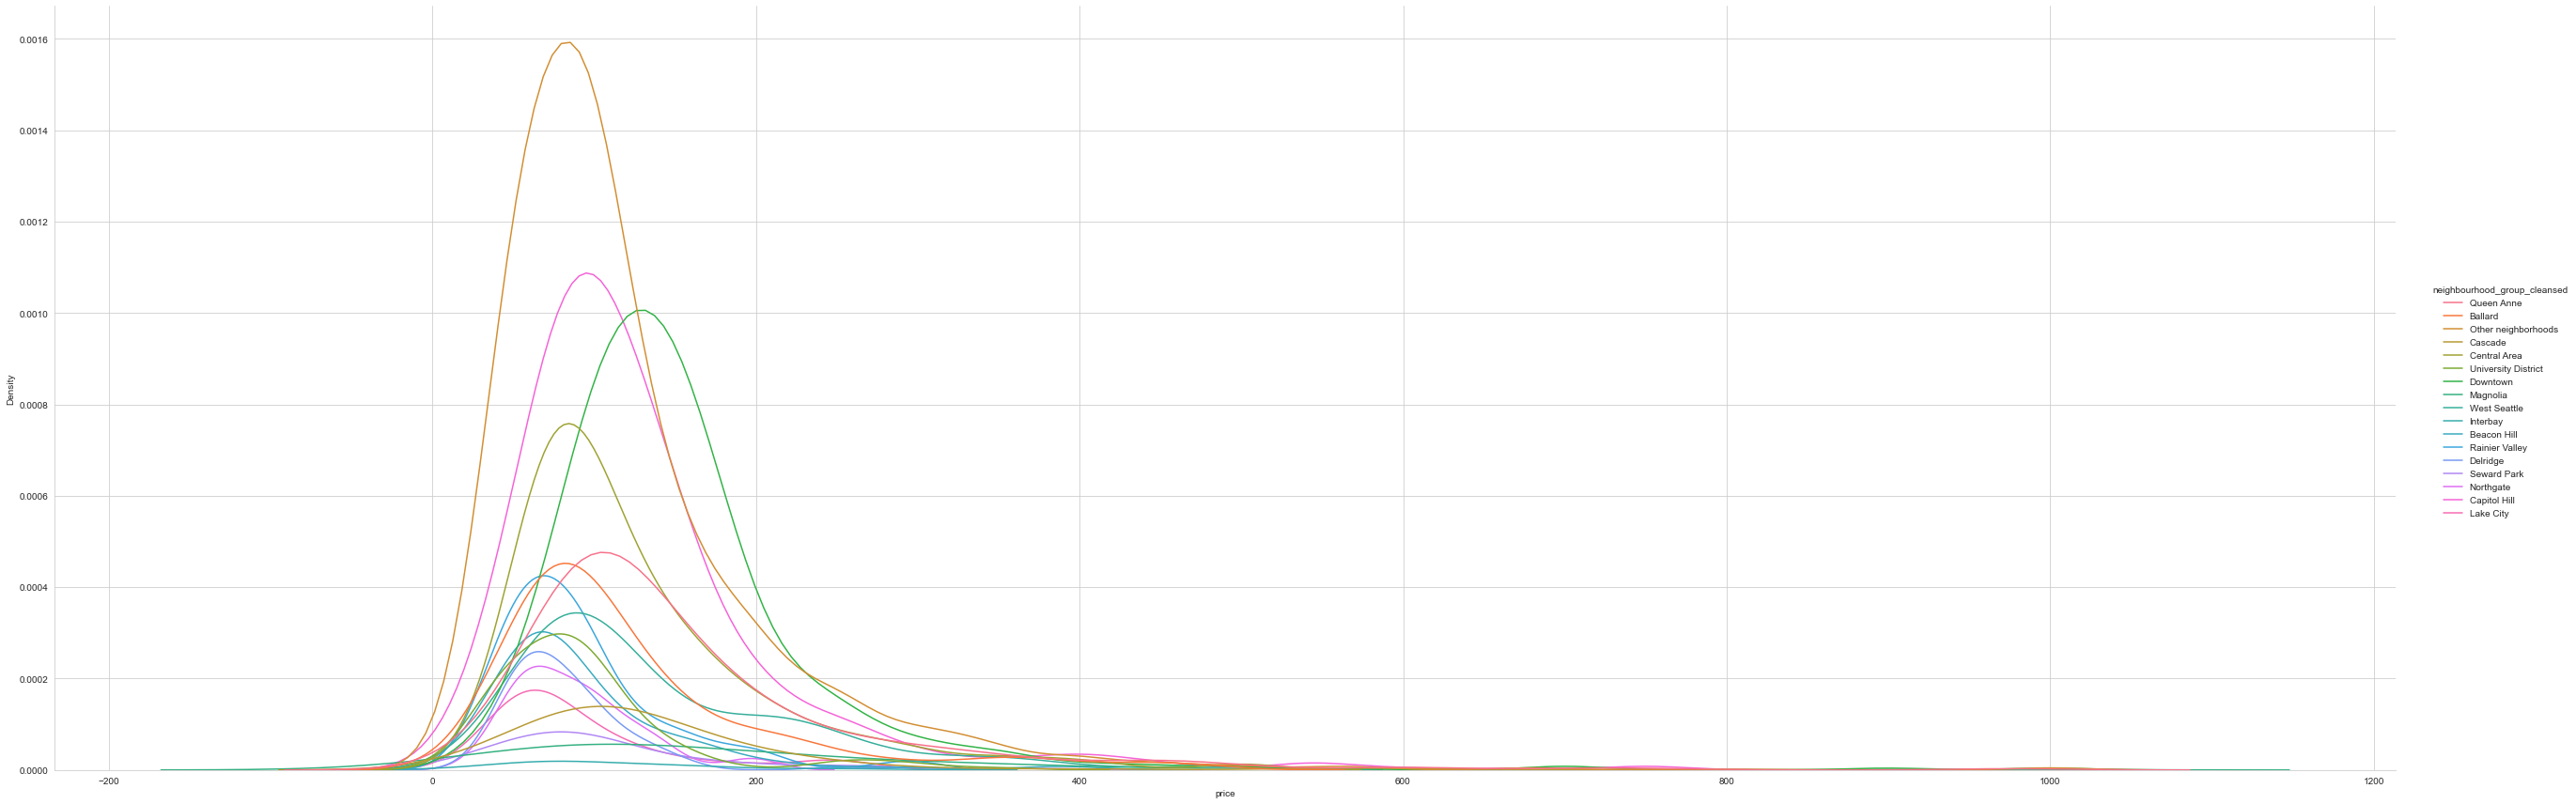

In [33]:
sns.displot(listings_clean, x="price", hue="neighbourhood_group_cleansed",kind="kde",  height=12, aspect=3);
plt.ylabel('Longitude',fontsize=20)
plt.xlabel('Latitude', fontsize=20)
ax.legend(loc='best', fontsize=50)
plt.title('Seattle Neighborhood Airbnb Room Types', fontsize=20);

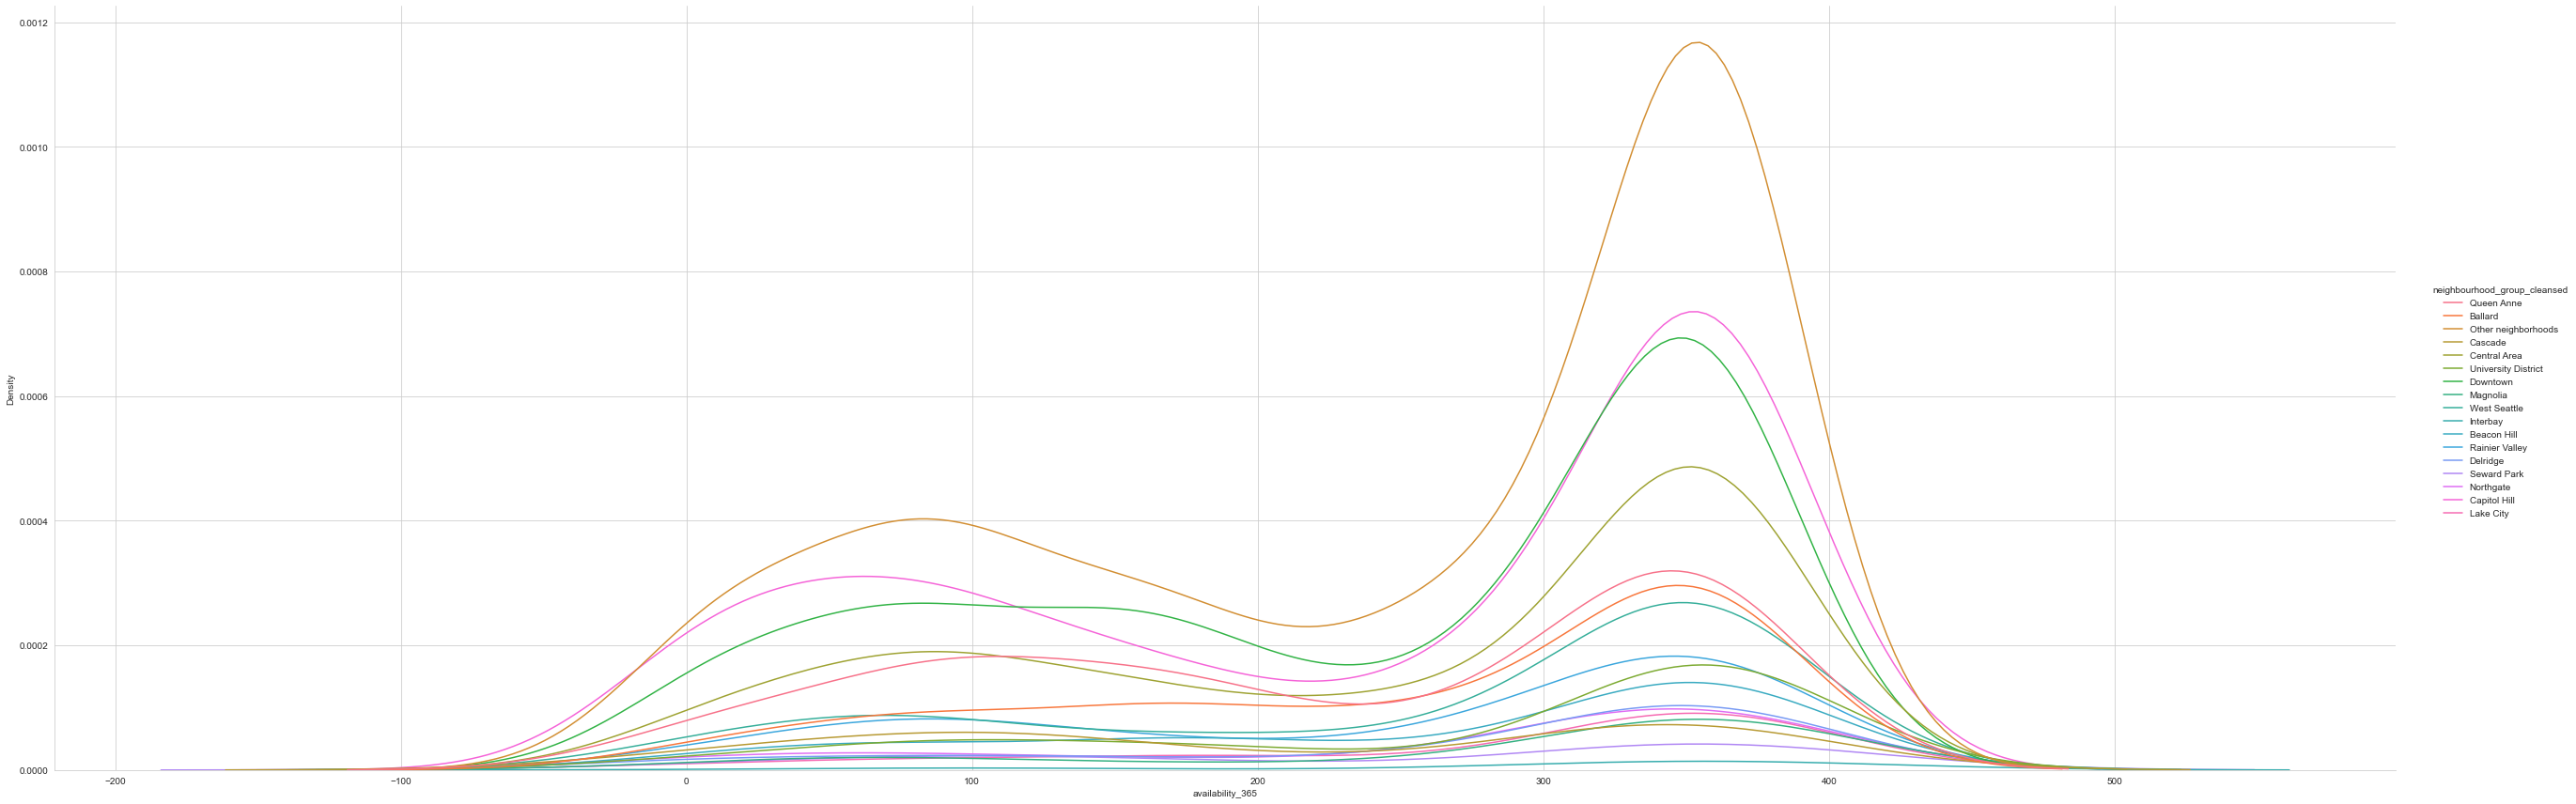

In [68]:
sns.displot(listings_clean, x="availability_365", hue="neighbourhood_group_cleansed", kind="kde", height=12, aspect=3);

In [ ]:
### Analyze Neighbourhood Listings on Map using alltitude and longtitude

In [80]:
neighbourhood_group_summary = listings_clean['neighbourhood_group_cleansed'].value_counts()[:10].sort_values(ascending=False)
neighbourhood_group = pd.DataFrame({'neighbourhood_group_cleansed':neighbourhood_group_summary.index}).merge(listings_clean, how='left')

No handles with labels found to put in legend.


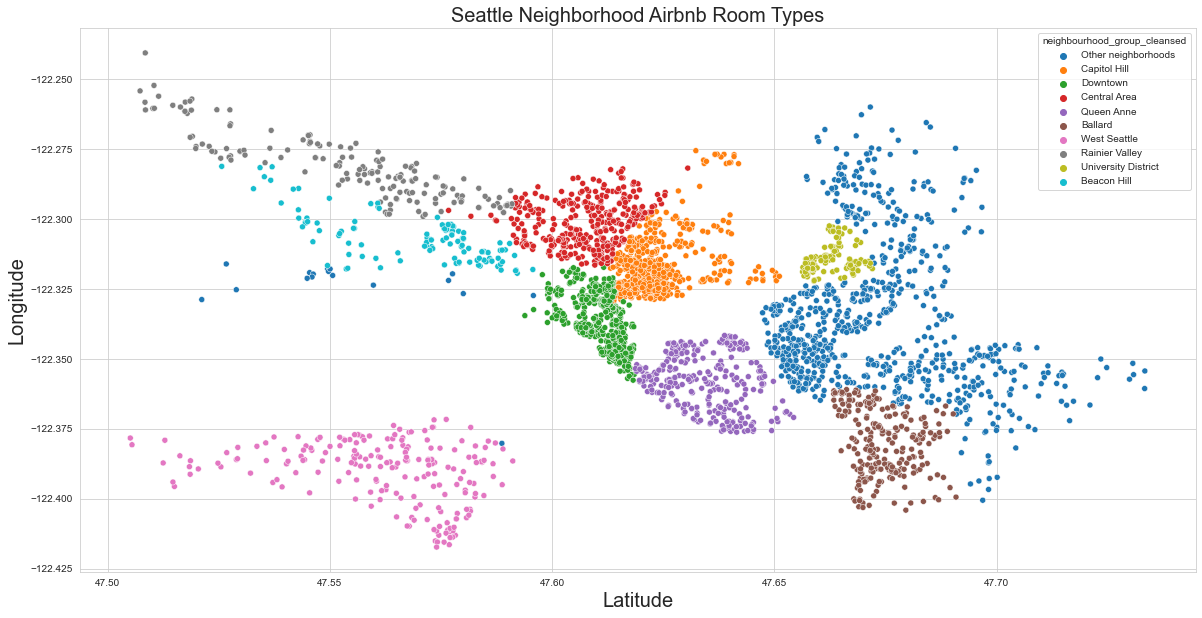

In [81]:
# Plotting top 10 most listed neighbourhoods by location
fig = plt.figure(figsize=(20,10))

# plt.subplot(1, 2, 1)
sns.scatterplot(data=neighbourhood_group,x='latitude',y='longitude',hue='neighbourhood_group_cleansed')
plt.ylabel('Longitude',fontsize=20)
plt.xlabel('Latitude', fontsize=20)
ax.legend(loc='best', fontsize=50)
plt.title('Seattle Neighborhood Airbnb Room Types', fontsize=20);

In [74]:
#Create Metrics related to each neighbourhood
neighbourhood_listing_DF = listings_clean.groupby('neighbourhood_group_cleansed').listing_id.count().reset_index(name='number_of_listings')
neighbourhood_availability_30_DF = listings_clean.groupby('neighbourhood_group_cleansed').availability_30.mean().reset_index(name = 'avg_monthly_availability')
neighbourhood_availability_90_DF = listings_clean.groupby('neighbourhood_group_cleansed').availability_90.mean().reset_index(name = 'avg_quarterly_availability')
neighbourhood_availability_365_DF = listings_clean.groupby('neighbourhood_group_cleansed').availability_365.mean().reset_index(name = 'avg_yearly_availability')
neighbourhood_price_DF = listings_clean.groupby('neighbourhood_group_cleansed').price.agg(['mean','median']).reset_index().rename(columns={'mean':'average_price','median':'median_price'})
#Merge all above dataframes
neighbourhood_DF = reduce(lambda x,y: pd.merge(x,y, on='neighbourhood_group_cleansed', how='outer'), [neighbourhood_listing_DF, neighbourhood_availability_30_DF, neighbourhood_availability_90_DF,neighbourhood_availability_365_DF,neighbourhood_price_DF])
neighbourhood_DF.sort_values(by=['avg_monthly_availability','average_price'], ascending=[True,False])

,neighbourhood_group_cleansed,number_of_listings,avg_monthly_availability,avg_quarterly_availability,avg_yearly_availability,average_price,median_price
3,Cascade,89,13.247191,49.325843,210.303371,140.101124,115.0
12,Queen Anne,295,14.833898,52.033898,226.454237,157.223729,119.0
0,Ballard,230,15.660870,54.769565,252.673913,124.682609,95.0
4,Central Area,369,15.693767,56.208672,245.409214,128.338753,100.0
2,Capitol Hill,567,16.012346,54.888889,233.982363,130.592593,105.0
10,Northgate,80,16.050000,59.950000,263.812500,88.550000,79.5
11,Other neighborhoods,794,16.465995,56.431990,245.164987,119.968514,99.0
13,Rainier Valley,159,16.911950,60.704403,244.742138,91.899371,80.0
16,West Seattle,203,17.748768,61.354680,255.911330,141.359606,109.0
1,Beacon Hill,118,17.796610,61.220339,256.525424,94.669492,75.0


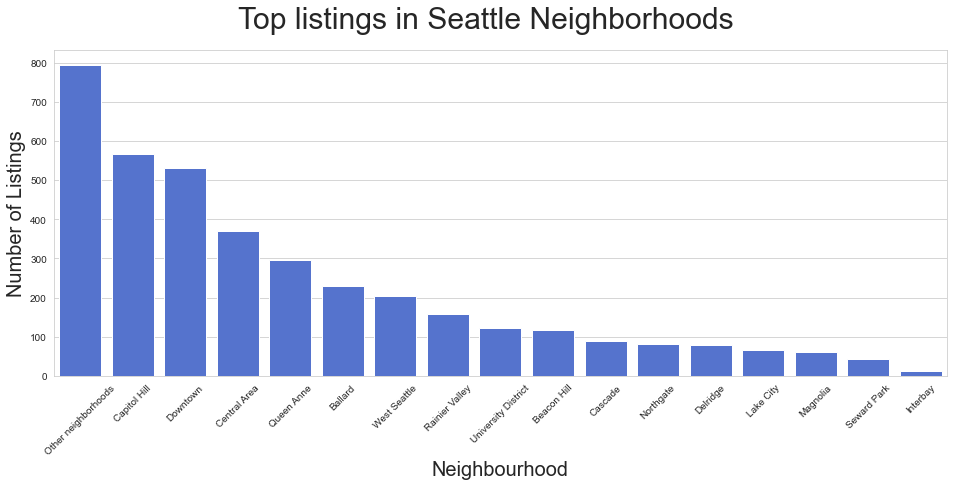

In [79]:
fig = plt.figure(figsize=(16,6))
fig.suptitle('Top listings in Seattle Neighborhoods', fontsize=30)
sns.barplot(data=neighbourhood_DF, x='neighbourhood_group_cleansed', y='number_of_listings', color='royalblue', order=neighbourhood_DF.sort_values('number_of_listings',ascending = False).neighbourhood_group_cleansed)
plt.xlabel("Neighbourhood",fontsize=20)
plt.ylabel("Number of Listings",fontsize=20)
plt.xticks(rotation=45);

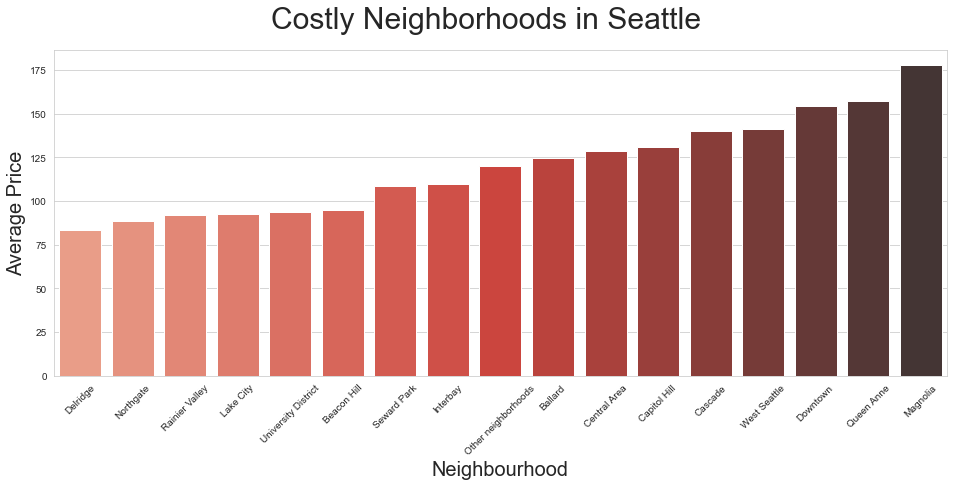

In [90]:
fig = plt.figure(figsize=(16,6))
fig.suptitle('Costly Neighborhoods in Seattle', fontsize=30)
sns.barplot(data=neighbourhood_DF, x='neighbourhood_group_cleansed', y='average_price', palette="Reds_d", order=neighbourhood_DF.sort_values('average_price',ascending = True).neighbourhood_group_cleansed)
plt.xlabel("Neighbourhood",fontsize=20)
plt.ylabel("Average Price",fontsize=20)
plt.xticks(rotation=45);

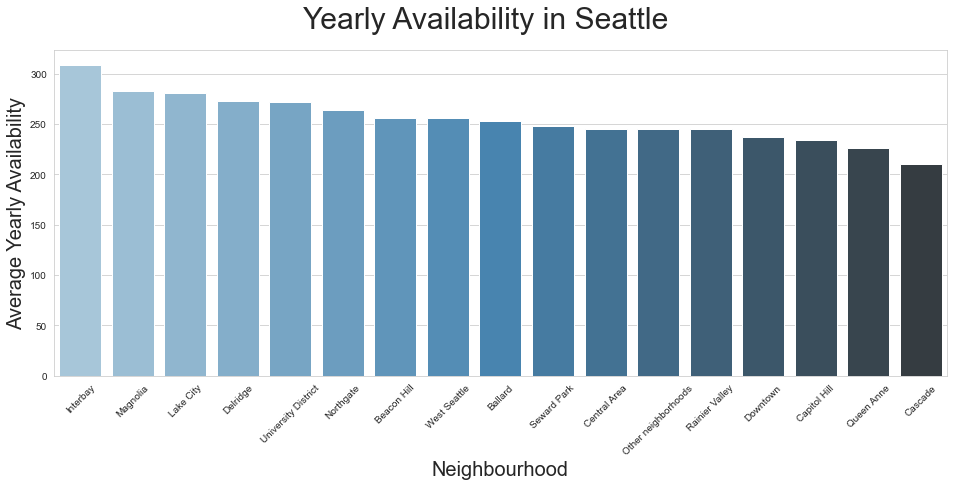

In [93]:
fig = plt.figure(figsize=(16,6))
fig.suptitle('Yearly Availability in Seattle', fontsize=30)
sns.barplot(data=neighbourhood_DF, x='neighbourhood_group_cleansed', y='avg_yearly_availability', palette="Blues_d", order=neighbourhood_DF.sort_values('avg_yearly_availability',ascending = False).neighbourhood_group_cleansed)
plt.xlabel("Neighbourhood",fontsize=20)
plt.ylabel("Average Yearly Availability",fontsize=20)
plt.xticks(rotation=45);

##### <font color= red >Here we have observed that below five neighbourhood are high in demand and has good rental price as well. </font>
* <font color= purple>__Cascade__
* __Queen Ann__
* __Downtown__
* __Capitol Hill__
* __Central Area__</font>


#####  It seems like, that <font color= green > Queen Anne, Downtown and Mangolia </font> Neighborhoods are up to $50 more expensive than the others.

### <font color= blue > Q2 :  What is the peak time to rent in Seattle?</font>

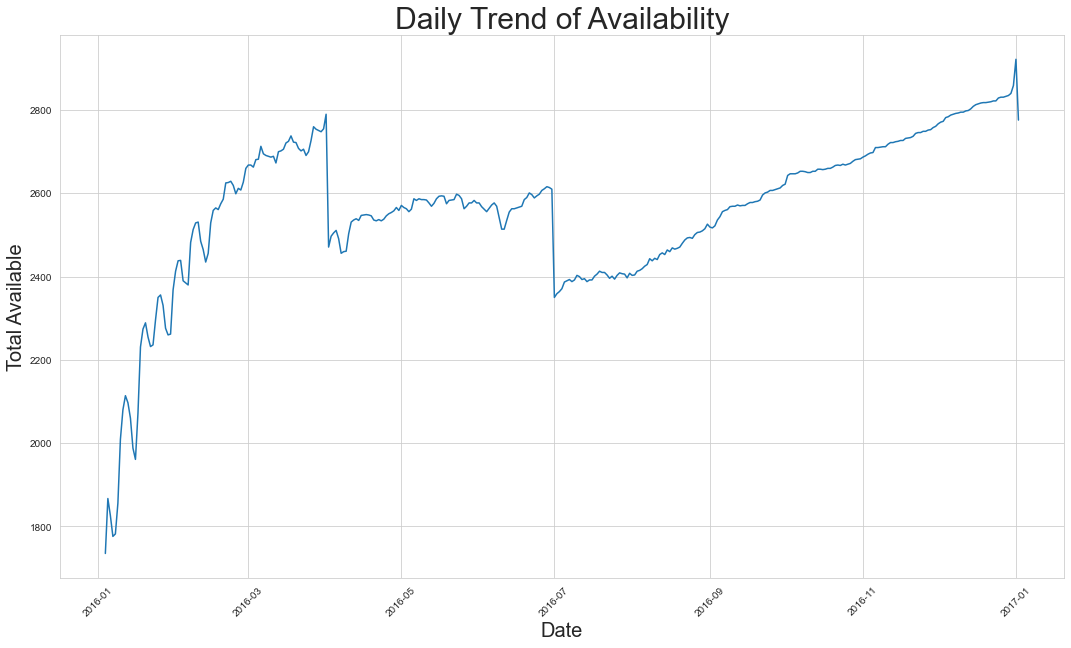

In [35]:
#Create a Month Dataframe
day_available_DF = calendar_clean.groupby(['date']).available.sum().reset_index(name='total_available')
sns.lineplot( x = "date",
             y = "total_available",
             data = day_available_DF)
plt.xlabel("Date",fontsize=20)
plt.ylabel("Total Available",fontsize=20)
plt.xticks(rotation=45)
plt.title('Daily Trend of Availability', fontsize=30);

In [78]:
#Create a Month Dataframe
available_DF = calendar_clean.groupby(['month']).available.sum().reset_index(name='total_available')
listing_DF = calendar_clean.groupby(['month']).listing_id.count().reset_index(name='total_listings')
month_DF = pd.merge(available_DF,listing_DF, on = "month", how = "inner")
month_DF['percent_available'] = (month_DF['total_available']/month_DF['total_listings']) * 100
month_DF.head()

,month,total_available,total_listings,percent_available
0,1,64937,114540,56.693731
1,2,73321,110722,66.220805
2,3,83938,118358,70.918738
3,4,76037,114540,66.384669
4,5,79971,118358,67.567042


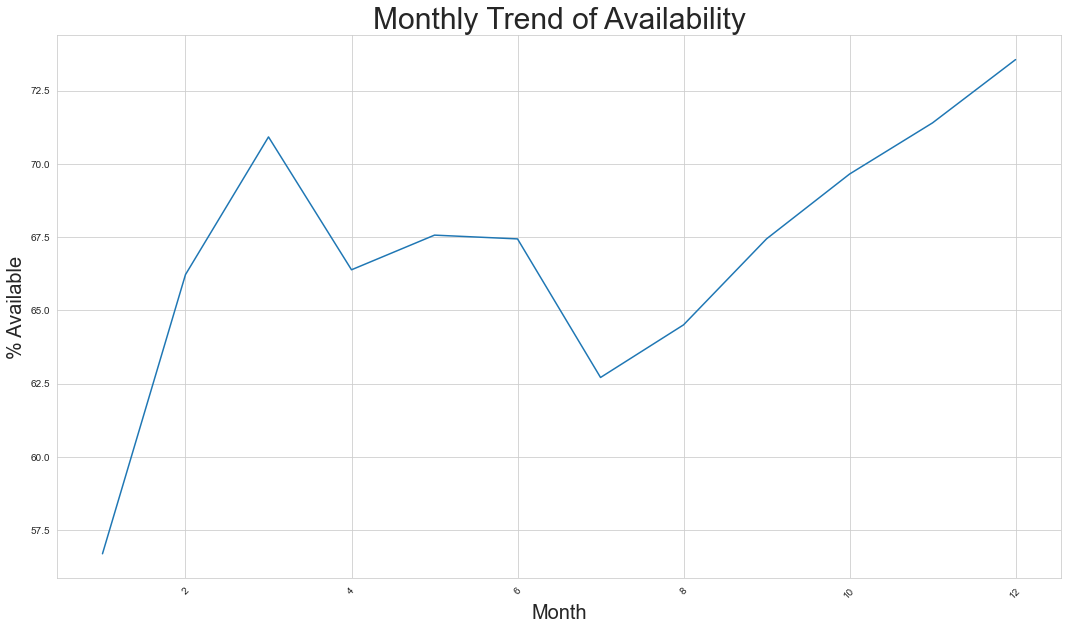

In [79]:

sns.lineplot( x = "month",
             y = "percent_available",
             data = month_DF)
plt.xlabel("Month",fontsize=20)
plt.ylabel("% Available",fontsize=20)
plt.xticks(rotation=45)
plt.title('Monthly Trend of Availability', fontsize=30);

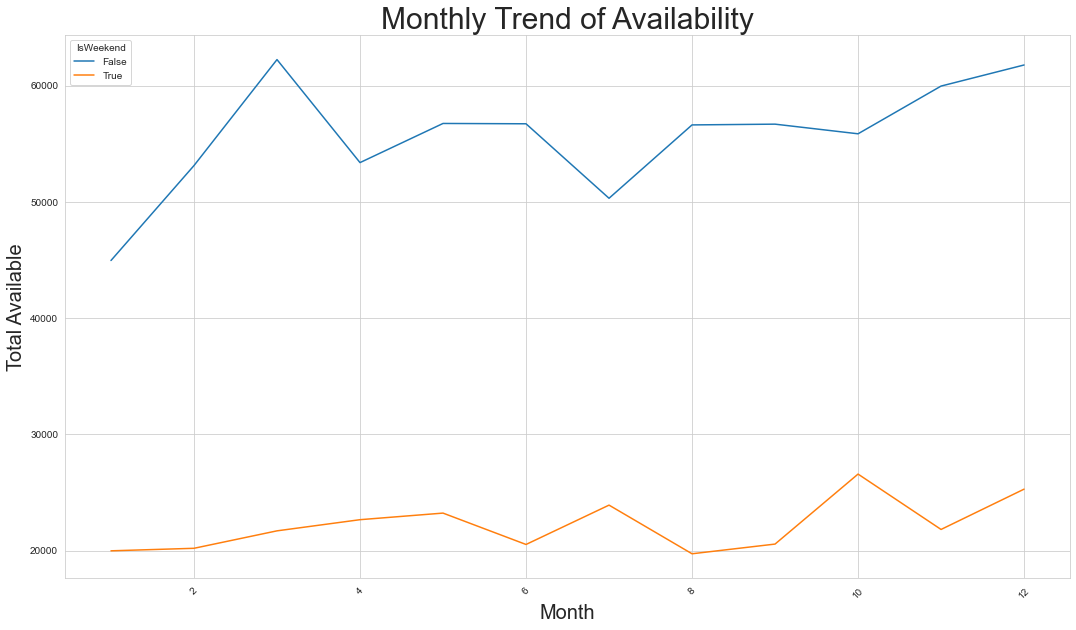

In [75]:
#Create a Month Dataframe
month_available_DF = calendar_clean.groupby(['month','IsWeekend']).available.sum().reset_index(name='total_available')
sns.lineplot( x = "month",
             y = "total_available",
             hue ="IsWeekend",
             data = month_available_DF)
plt.xlabel("Month",fontsize=20)
plt.ylabel("Total Available",fontsize=20)
plt.xticks(rotation=45)
plt.title('Monthly Trend of Availability', fontsize=30);

In [37]:
date_columns = list(listings_clean.select_dtypes(include = ["datetime"]).columns)
date_columns

['host_since', 'first_review', 'last_review']

In [38]:
#Merge all above dataframes
listings_calendar = reduce(lambda x,y: pd.merge(x,y, on='listing_id', how='outer'), [listings_clean,calendar_clean])
listings_calendar.head()

,listing_id,name,summary,space,description,host_id,host_name,host_since,host_about,host_response_time,...,day,day_name,dayofweek,IsWeekend,month,month_name,month_year,quarter,quarter_year,year
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,956883,Maija,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,...,4,Monday,0,False,1,January,2016-01,1,2016Q1,2016
1,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,956883,Maija,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,...,5,Tuesday,1,False,1,January,2016-01,1,2016Q1,2016
2,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,956883,Maija,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,...,6,Wednesday,2,False,1,January,2016-01,1,2016Q1,2016
3,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,956883,Maija,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,...,7,Thursday,3,False,1,January,2016-01,1,2016Q1,2016
4,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,956883,Maija,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,...,8,Friday,4,False,1,January,2016-01,1,2016Q1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393565,10208623,Large Lakefront Apartment,"All hardwood floors, fireplace, 65"" TV with Xb...",NaN,"All hardwood floors, fireplace, 65"" TV with Xb...",14703116,Gil,2014-04-25,NaN,within a day,...,29,Thursday,3,False,12,December,2016-12,4,2016Q4,2016
1393566,10208623,Large Lakefront Apartment,"All hardwood floors, fireplace, 65"" TV with Xb...",NaN,"All hardwood floors, fireplace, 65"" TV with Xb...",14703116,Gil,2014-04-25,NaN,within a day,...,30,Friday,4,False,12,December,2016-12,4,2016Q4,2016
1393567,10208623,Large Lakefront Apartment,"All hardwood floors, fireplace, 65"" TV with Xb...",NaN,"All hardwood floors, fireplace, 65"" TV with Xb...",14703116,Gil,2014-04-25,NaN,within a day,...,31,Saturday,5,True,12,December,2016-12,4,2016Q4,2016
1393568,10208623,Large Lakefront Apartment,"All hardwood floors, fireplace, 65"" TV with Xb...",NaN,"All hardwood floors, fireplace, 65"" TV with Xb...",14703116,Gil,2014-04-25,NaN,within a day,...,1,Sunday,6,True,1,January,2017-01,1,2017Q1,2017


In [41]:
#Merge all above dataframes
listings_calendar = pd.merge(listings_clean,calendar_clean, on = "listing_id", how = "inner")
listings_calendar.head()

,listing_id,name,summary,space,description,host_id,host_name,host_since,host_about,host_response_time,...,day,day_name,dayofweek,IsWeekend,month,month_name,month_year,quarter,quarter_year,year
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,956883,Maija,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,...,4,Monday,0,False,1,January,2016-01,1,2016Q1,2016
1,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,956883,Maija,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,...,5,Tuesday,1,False,1,January,2016-01,1,2016Q1,2016
2,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,956883,Maija,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,...,6,Wednesday,2,False,1,January,2016-01,1,2016Q1,2016
3,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,956883,Maija,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,...,7,Thursday,3,False,1,January,2016-01,1,2016Q1,2016
4,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,956883,Maija,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,...,8,Friday,4,False,1,January,2016-01,1,2016Q1,2016


In [220]:
calendar_month = calendar_clean[['listing_id','month','month_name','month_year','quarter','quarter_year']].drop_duplicates()
#Merge Listing and Calendar Data Frame
listings_calendar = pd.merge(listings_clean,calendar_month, on = "listing_id", how = "inner")

In [67]:
calendar_month = calendar_clean[['listing_id','month','month_name','month_year','quarter','quarter_year','price_2']].drop_duplicates()
#Merge Listing and Calendar Data Frame
listings_calendar = pd.merge(listings_clean,calendar_month, on = "listing_id", how = "inner")

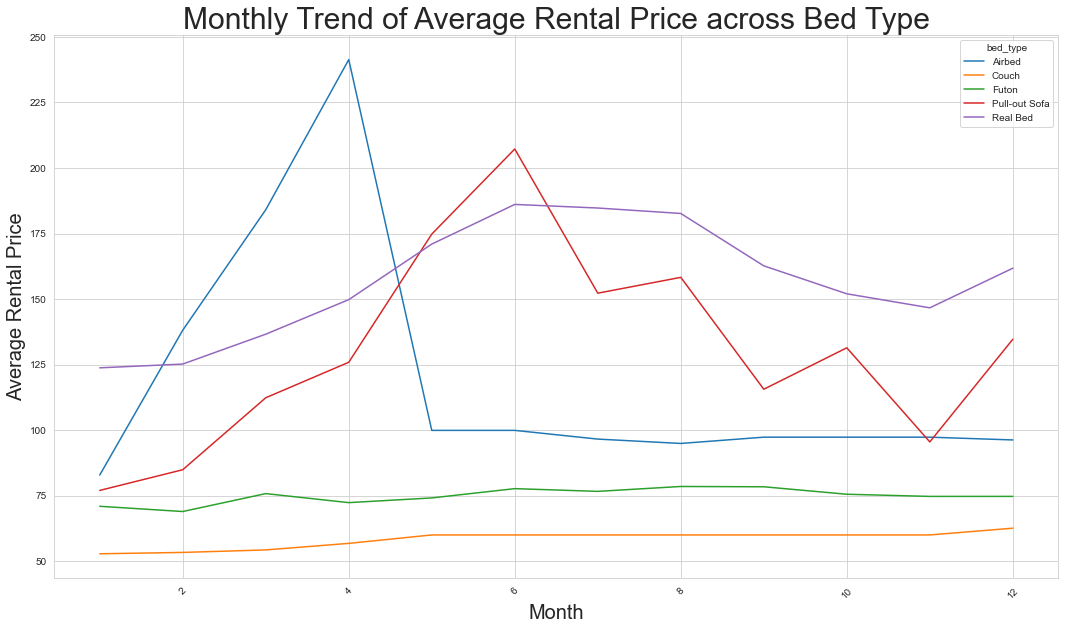

In [71]:
#Create a Month Dataframe
month_price_DF = listings_calendar.groupby(['month','bed_type']).price_2.mean().reset_index(name='avg_price')
sns.lineplot( x = "month",
             y = "avg_price",
             hue ="bed_type",
             data = month_price_DF)
plt.xlabel("Month",fontsize=20)
plt.ylabel("Average Rental Price",fontsize=20)
plt.xticks(rotation=45)
plt.title('Monthly Trend of Average Rental Price across Bed Type', fontsize=30);

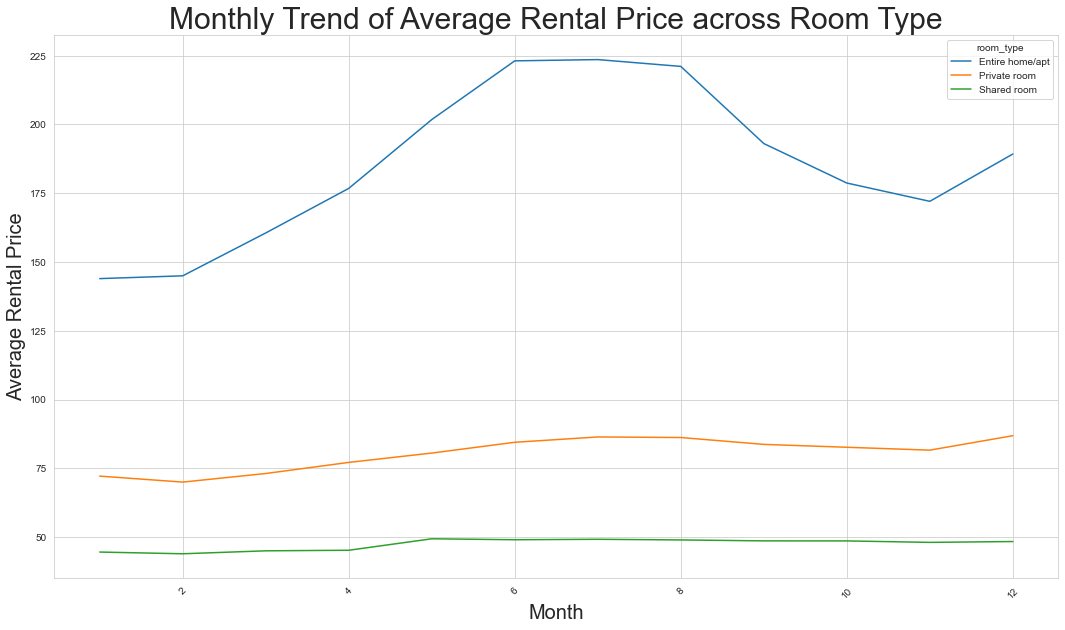

In [72]:
#Create a Month Dataframe
month_price_DF = listings_calendar.groupby(['month','room_type']).price_2.mean().reset_index(name='avg_price')
sns.lineplot( x = "month",
             y = "avg_price",
             hue ="room_type",
             data = month_price_DF)
plt.xlabel("Month",fontsize=20)
plt.ylabel("Average Rental Price",fontsize=20)
plt.xticks(rotation=45)
plt.title('Monthly Trend of Average Rental Price across Room Type', fontsize=30);

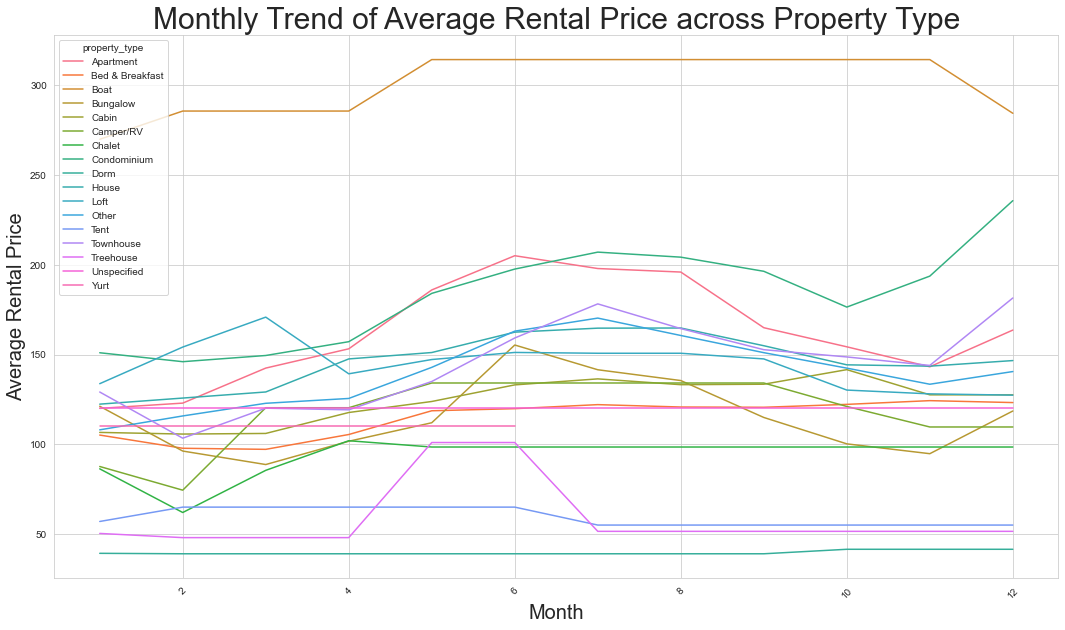

In [73]:
#Create a Month Dataframe
month_price_DF = listings_calendar.groupby(['month','property_type']).price_2.mean().reset_index(name='avg_price')
sns.lineplot( x = "month",
             y = "avg_price",
             hue ="property_type",
             data = month_price_DF)
plt.xlabel("Month",fontsize=20)
plt.ylabel("Average Rental Price",fontsize=20)
plt.xticks(rotation=45)
plt.title('Monthly Trend of Average Rental Price across Property Type', fontsize=30);

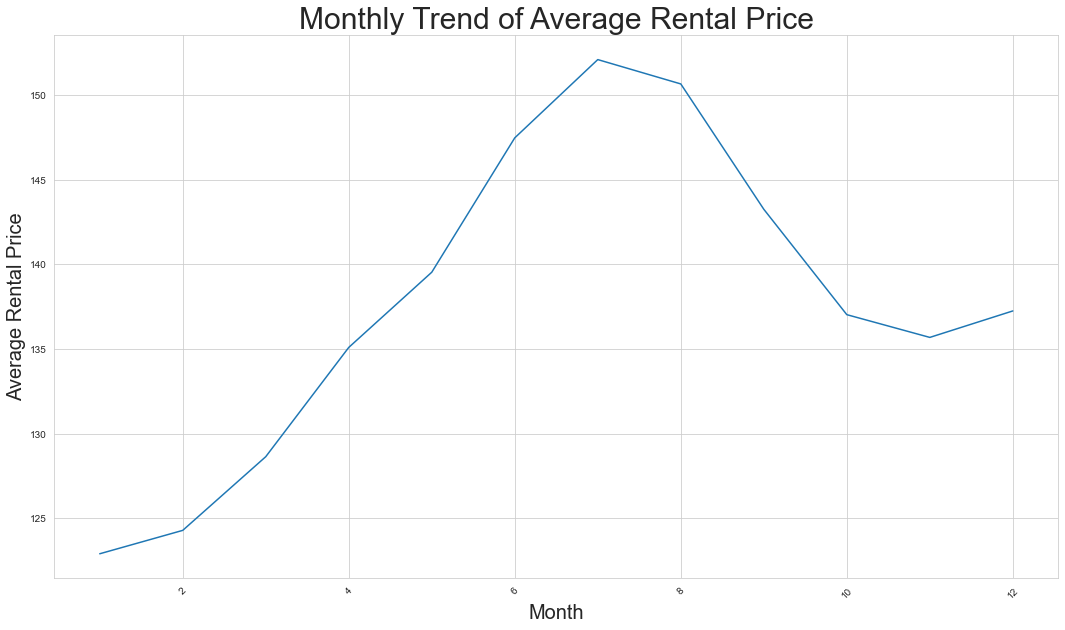

In [80]:
#Create a Month Dataframe
month_price_DF = calendar_clean.groupby(['month']).price_2.mean().reset_index(name='avg_price')
sns.lineplot( x = "month",
             y = "avg_price",
             data = month_price_DF)
plt.xlabel("Month",fontsize=20)
plt.ylabel("Average Rental Price",fontsize=20)
plt.xticks(rotation=45)
plt.title('Monthly Trend of Average Rental Price', fontsize=30);

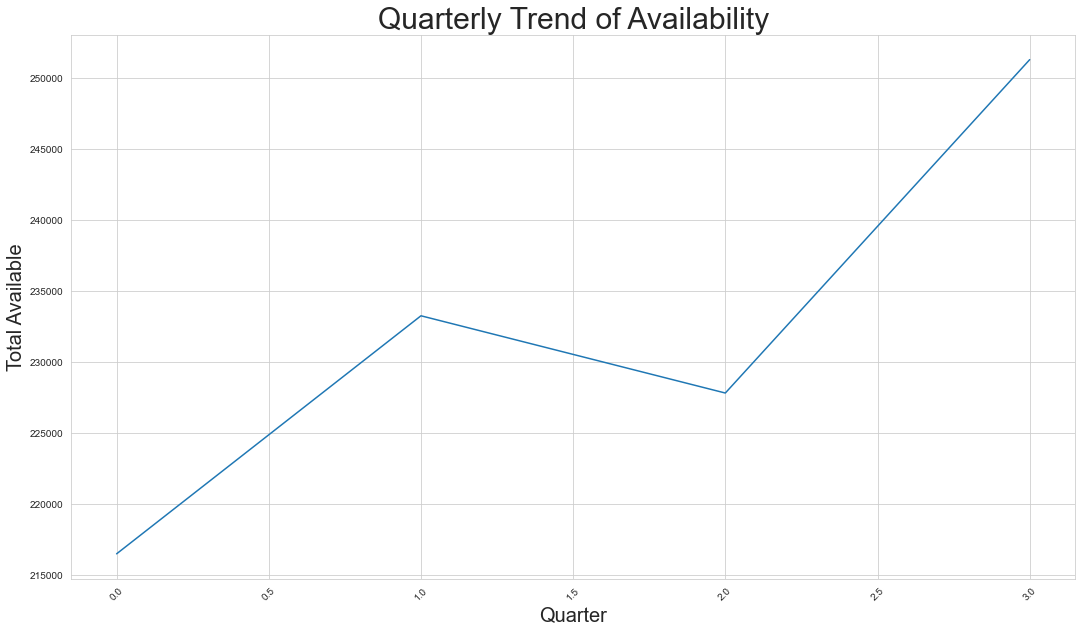

In [138]:
#Create a Quarter Dataframe
quarter_available_DF = calendar_clean[calendar_clean['year']==2016].groupby(['quarter_year']).available.sum().reset_index(name='total_available')
quarter_available_DF.set_index('quarter_year')
sns.lineplot( x = quarter_available_DF.index,
             y = "total_available",
             data = quarter_available_DF)
plt.xlabel("Quarter",fontsize=20)
plt.ylabel("Total Available",fontsize=20)
plt.xticks(rotation=45)
plt.title('Quarterly Trend of Availability', fontsize=30);

### <font color= blue > Q3 :  What will be the fair price for renting in a particular neighborhood in Seattle?</font>

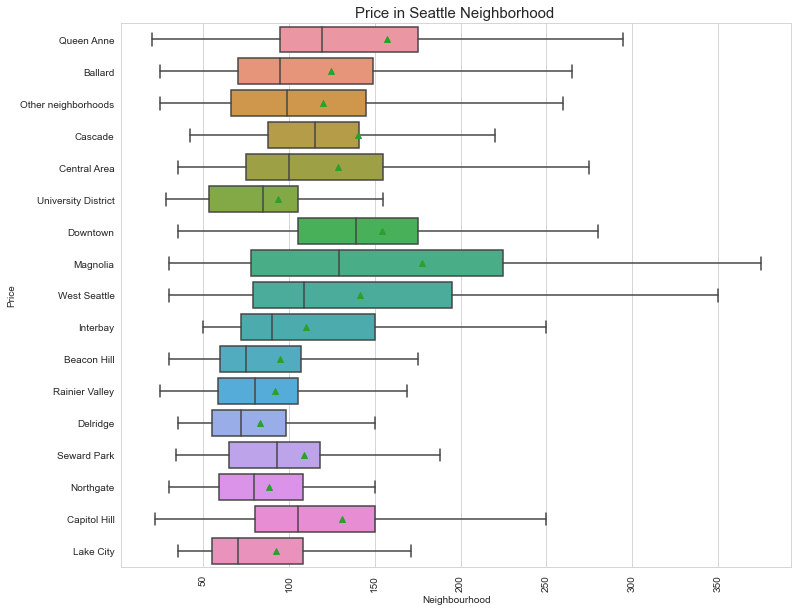

In [134]:
plt.figure(figsize=(12,10))
sns.boxplot(x="price", y="neighbourhood_group_cleansed",orient='h' ,data=listings_clean, showmeans=True, showfliers = False)
plt.xlabel("Neighbourhood",fontsize=10)
plt.ylabel("Price",fontsize=10)
plt.xticks(rotation=90)
plt.title('Price in Seattle Neighborhood ', fontsize=15);

#### Listings Based on Property Type

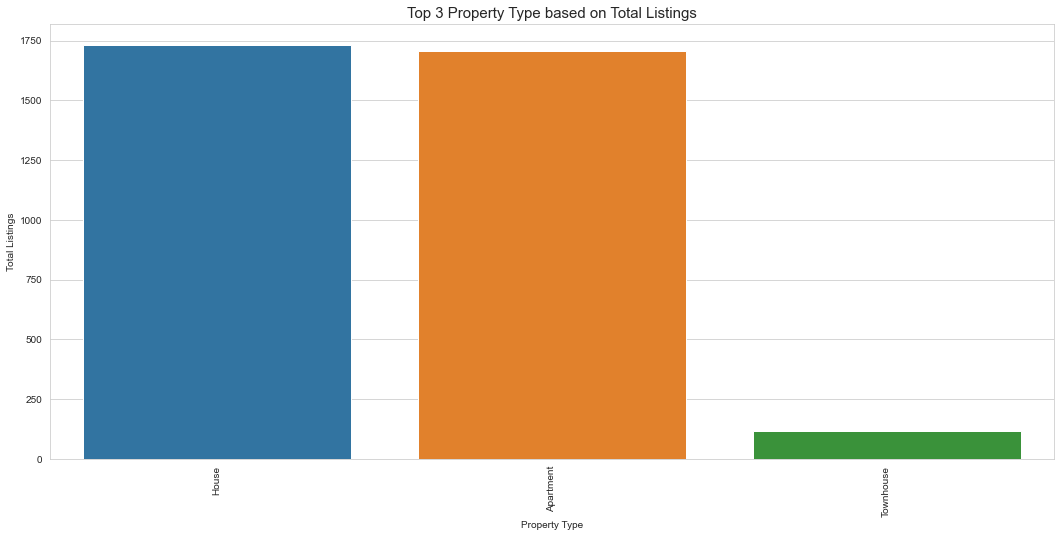

In [111]:
property_type_df = listings_clean.groupby(['property_type']).listing_id.count().nlargest(3).reset_index(name='total_listings')
top_3_property_type = property_type_df.property_type.unique().tolist()
plt.figure(figsize=(18,8))
sns.barplot(x="property_type", y="total_listings", data=property_type_df)
plt.xlabel("Property Type",fontsize=10)
plt.ylabel("Total Listings",fontsize=10)
plt.xticks(rotation=90)
plt.title('Top 3 Property Type based on Total Listings', fontsize=15);

#### Listings Based on Room Type

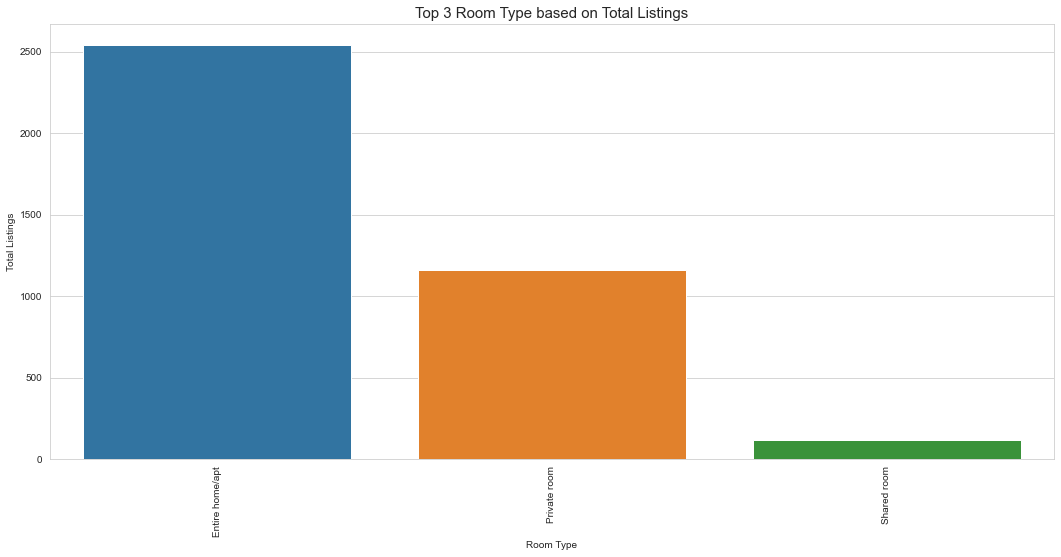

In [112]:
room_type_df = listings_clean.groupby(['room_type']).listing_id.count().nlargest(3).reset_index(name='total_listings')
top_3_room_type = room_type_df.room_type.unique().tolist()
plt.figure(figsize=(18,8))
sns.barplot(x="room_type", y="total_listings", data=room_type_df)
plt.xlabel("Room Type",fontsize=10)
plt.ylabel("Total Listings",fontsize=10)
plt.xticks(rotation=90)
plt.title('Top 3 Room Type based on Total Listings', fontsize=15);

#### Price in Seattle Neighborhood across different Rental Property

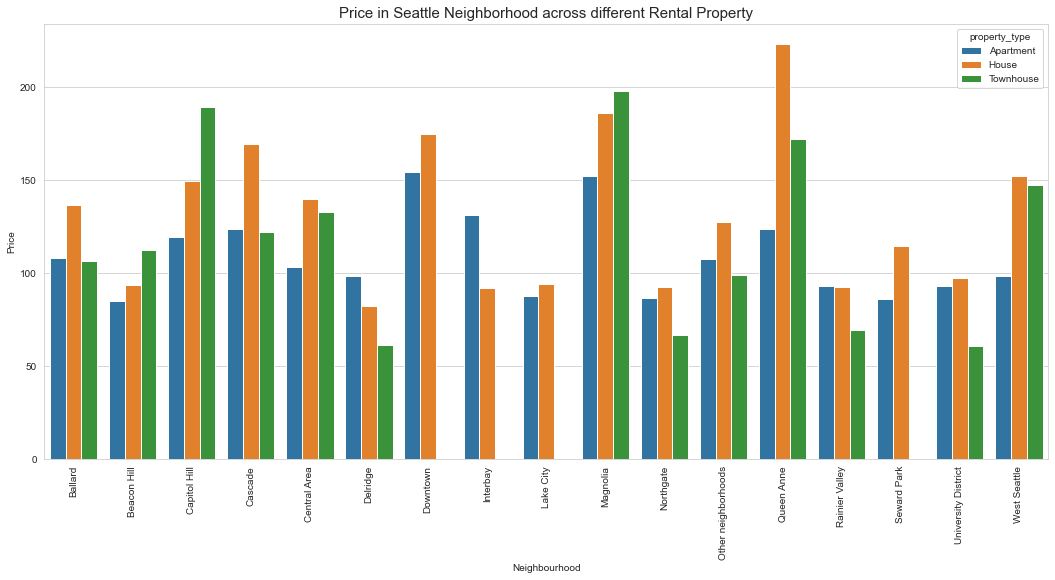

In [119]:
property_type_price_df = listings_clean.groupby(['neighbourhood_group_cleansed','property_type']).price.mean().reset_index()
property_type_price_df = property_type_price_df[property_type_price_df['property_type'].isin(top_3_property_type)]
plt.figure(figsize=(18,8))
sns.barplot(x="neighbourhood_group_cleansed", y="price",hue="property_type", data=property_type_price_df)
plt.xlabel("Neighbourhood",fontsize=10)
plt.ylabel("Price",fontsize=10)
plt.xticks(rotation=90)
plt.title('Price in Seattle Neighborhood across different Rental Property', fontsize=15);

#### Price in Seattle Neighborhood across different Room Type

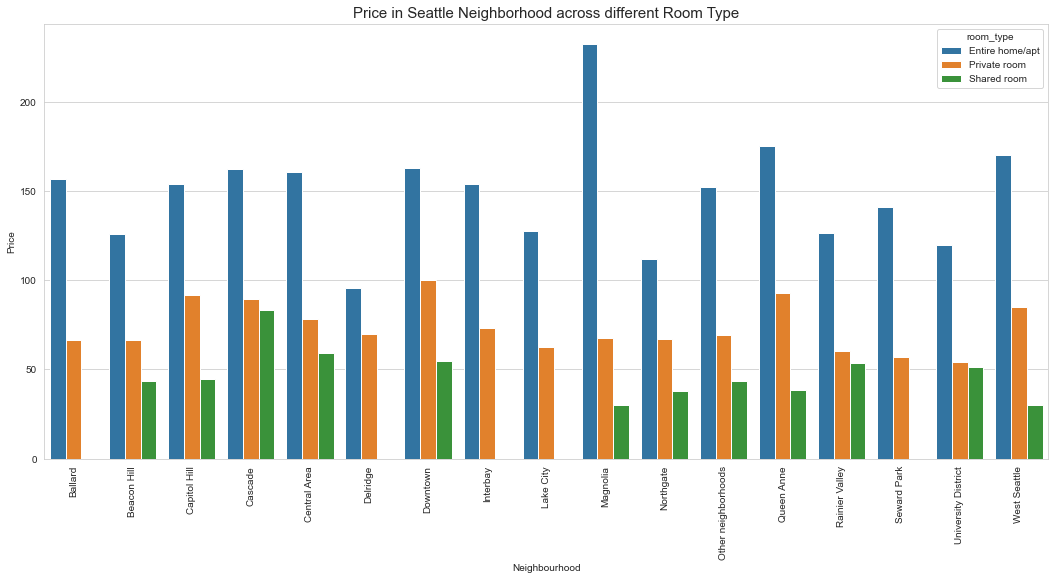

In [120]:
room_type_price_df = listings_clean.groupby(['neighbourhood_group_cleansed','room_type']).price.mean().reset_index()
room_type_price_df = room_type_price_df[room_type_price_df['room_type'].isin(top_3_room_type)]
plt.figure(figsize=(18,8))
sns.barplot(x="neighbourhood_group_cleansed", y="price",hue="room_type", data=room_type_price_df)
plt.xlabel("Neighbourhood",fontsize=10)
plt.ylabel("Price",fontsize=10)
plt.xticks(rotation=90)
plt.title('Price in Seattle Neighborhood across different Room Type', fontsize=15);

listings_clean.groupby(['accommodates_bin']).listing_id.count().reset_index()

In [143]:
listings_clean['price_per_person'] = listings_clean['price']/listings_clean['accommodates']

#### Price per Person in Seattle Neighborhood

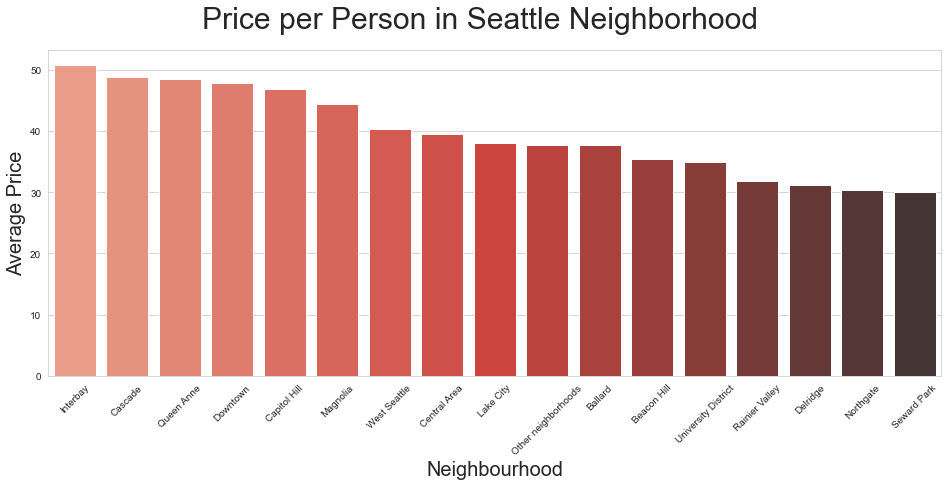

In [156]:
accommodates_price_df = listings_clean.groupby(['neighbourhood_group_cleansed']).price_per_person.mean().reset_index()
fig = plt.figure(figsize=(16,6))
fig.suptitle('Price per Person in Seattle Neighborhood', fontsize=30)
sns.barplot(data=accommodates_price_df, x='neighbourhood_group_cleansed', y='price_per_person', palette="Reds_d", order=accommodates_price_df.sort_values('price_per_person',ascending = False).neighbourhood_group_cleansed)
plt.xlabel("Neighbourhood",fontsize=20)
plt.ylabel("Average Price",fontsize=20)
plt.xticks(rotation=45);

#### Price per Person in Seattle Neighborhood across different Room Type

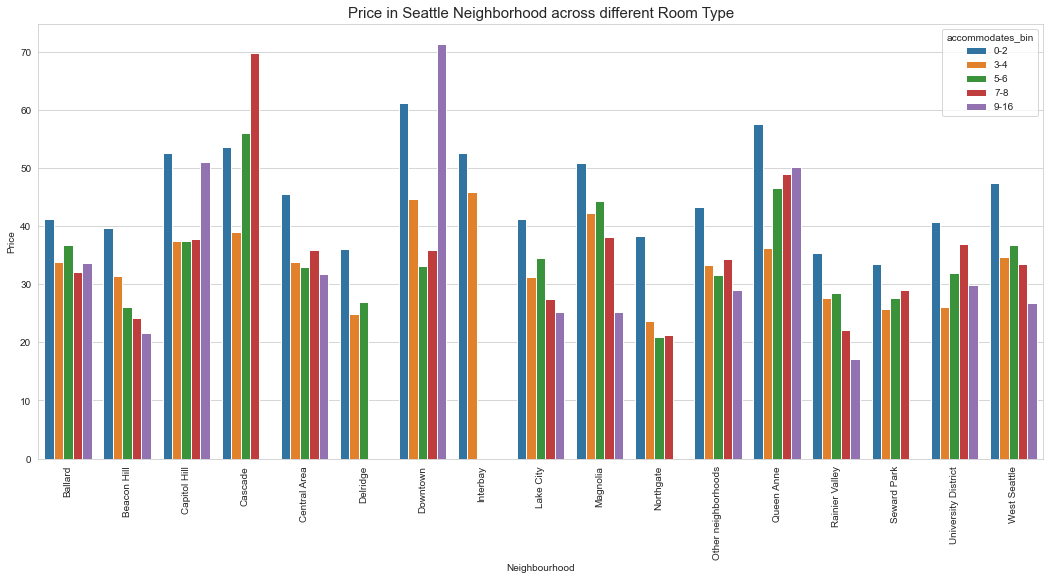

In [145]:
accommodates_price_df = listings_clean.groupby(['neighbourhood_group_cleansed','accommodates_bin']).price_per_person.mean().reset_index()
plt.figure(figsize=(18,8))
sns.barplot(x="neighbourhood_group_cleansed", y="price_per_person",hue="accommodates_bin", data=accommodates_price_df)
plt.xlabel("Neighbourhood",fontsize=10)
plt.ylabel("Price",fontsize=10)
plt.xticks(rotation=90)
plt.title('Price per Person in Seattle Neighborhood across different Room Type', fontsize=15);

### <font color= blue > Q4 :  Do good amenities or good reviews lead to a higher price in daily rent?</font>


In [150]:
neigh_group_rev_price = listings_clean.groupby('neighbourhood_group_cleansed')['price','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month'].aggregate(['mean'])
neigh_group_rev_price.columns = ['price','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month']
neigh_group_rev_price = neigh_group_rev_price.reset_index()
neigh_group_rev_price

,neighbourhood_group_cleansed,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,Ballard,124.682609,95.608696,9.773913,9.721739,9.917391,9.939130,9.804348,9.639130,2.404913
1,Beacon Hill,94.669492,94.271186,9.644068,9.533898,9.855932,9.847458,9.211864,9.440678,2.318814
2,Capitol Hill,130.592593,94.527337,9.654321,9.534392,9.820106,9.839506,9.857143,9.472663,1.923757
3,Cascade,140.101124,93.415730,9.539326,9.460674,9.865169,9.865169,9.685393,9.426966,1.733596
4,Central Area,128.338753,96.008130,9.794038,9.701897,9.856369,9.872629,9.558266,9.631436,2.109919
5,Delridge,83.278481,95.886076,9.873418,9.784810,9.987342,9.974684,9.341772,9.734177,2.068481
6,Downtown,154.405660,94.243396,9.628302,9.628302,9.700000,9.773585,9.801887,9.375472,2.236302
7,Interbay,109.727273,94.181818,9.727273,9.818182,9.727273,9.818182,9.272727,9.727273,1.934545
8,Lake City,92.671642,94.641791,9.776119,9.611940,9.865672,9.850746,9.388060,9.641791,1.544030
9,Magnolia,177.672131,94.295082,9.590164,9.573770,9.868852,9.901639,9.704918,9.540984,1.540656


In [178]:
listings_clean.neighbourhood_group_cleansed.unique()

array(['Queen Anne', 'Ballard', 'Other neighborhoods', 'Cascade',
       'Central Area', 'University District', 'Downtown', 'Magnolia',
       'West Seattle', 'Interbay', 'Beacon Hill', 'Rainier Valley',
       'Delridge', 'Seward Park', 'Northgate', 'Capitol Hill',
       'Lake City'], dtype=object)

In [179]:
# As per previous anlaysis
top_4_neighbourhood = ['Queen Anne','Downtown','Capitol Hill','Central Area']
top_4_df = listings_clean[listings_clean['neighbourhood_group_cleansed'].isin(top_4_neighbourhood)]
top_4_df.price.head()

0     85.0
1    150.0
2    975.0
3    100.0
4    450.0
Name: price, dtype: float64

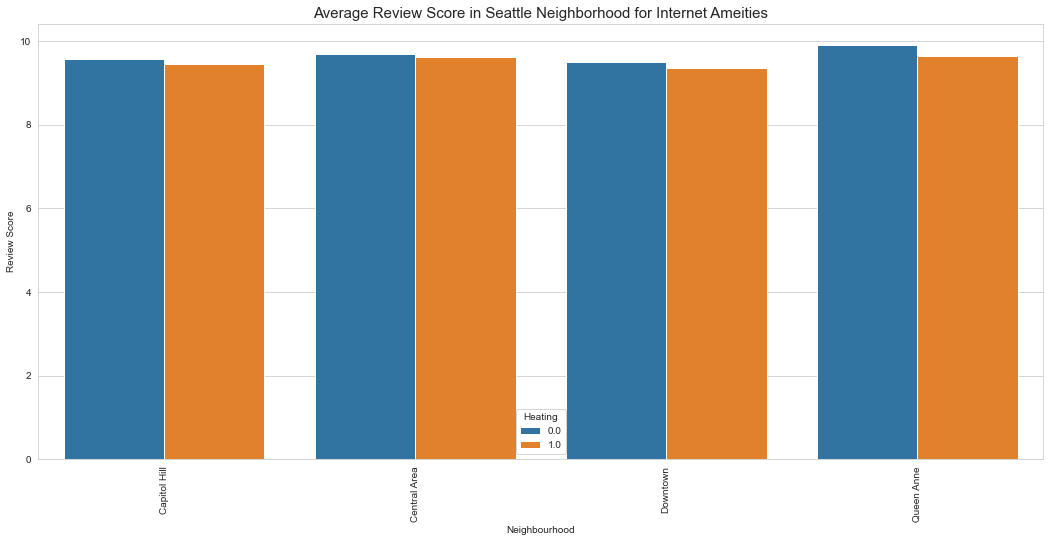

In [187]:
top_4_price_df = top_4_df.groupby(['neighbourhood_group_cleansed','Heating']).review_scores_value.mean().reset_index()
plt.figure(figsize=(18,8))
sns.barplot(x="neighbourhood_group_cleansed", y="review_scores_value",hue="Heating", data=top_4_price_df)
plt.xlabel("Neighbourhood",fontsize=10)
plt.ylabel("Review Score",fontsize=10)
plt.xticks(rotation=90)
plt.title('Average Review Score in Seattle Neighborhood for Internet Ameities', fontsize=15);

In [199]:
internet_df = listings_clean.groupby(['Internet']).price.mean().reset_index()
internet_df.columns = ['id','internet_price']
heating_df = listings_clean.groupby(['Heating']).price.mean().reset_index()
heating_df.columns = ['id','heating_price']
kitchen_df = listings_clean.groupby(['Kitchen']).price.mean().reset_index()
kitchen_df.columns = ['id','kitchen_price']

In [200]:
#Merge all above dataframes
all_DF = reduce(lambda x,y: pd.merge(x,y, on='id', how='inner'), [internet_df, heating_df, kitchen_df])
all_DF

,id,internet_price,heating_price,kitchen_price
0,0.0,116.317460,121.256545,94.764557
1,1.0,128.374052,128.330025,131.808647


In [ ]:
sns.barplot(x="neighbourhood_group_cleansed", y="review_scores_value",hue="Heating", data=top_4_price_df)

<Figure size 576x1296 with 0 Axes>

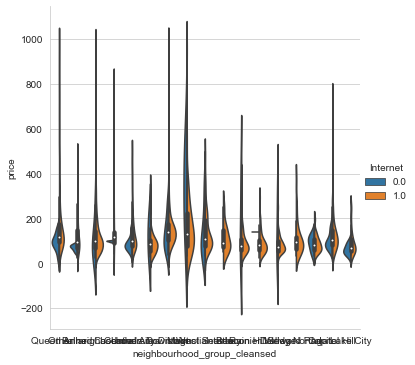

In [203]:
plt.figure(figsize=(8,18))
sns.catplot(x="neighbourhood_group_cleansed", y="price", hue="Internet",
            kind="violin", split=True, data=listings_clean);

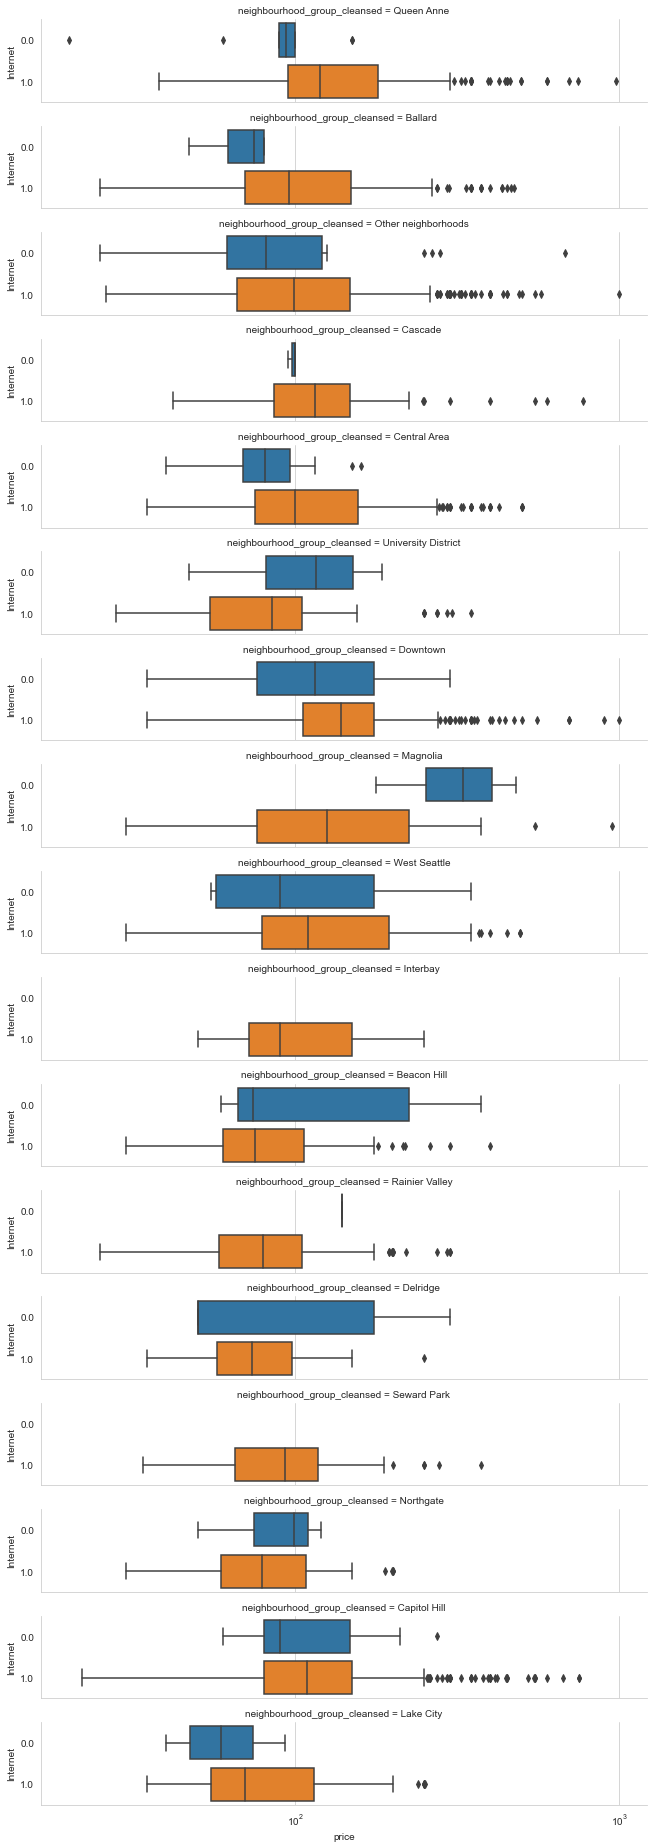

In [209]:
g = sns.catplot(x="price", y="Internet", row="neighbourhood_group_cleansed",
                kind="box", orient="h", height=1.5, aspect=6,
                data=listings_clean)
g.set(xscale="log");

In [192]:
pivot = pd.pivot_table(
    data=price_df,
    index='price'
)
pivot

,Internet
price,
116.317460,0.0
128.374052,1.0


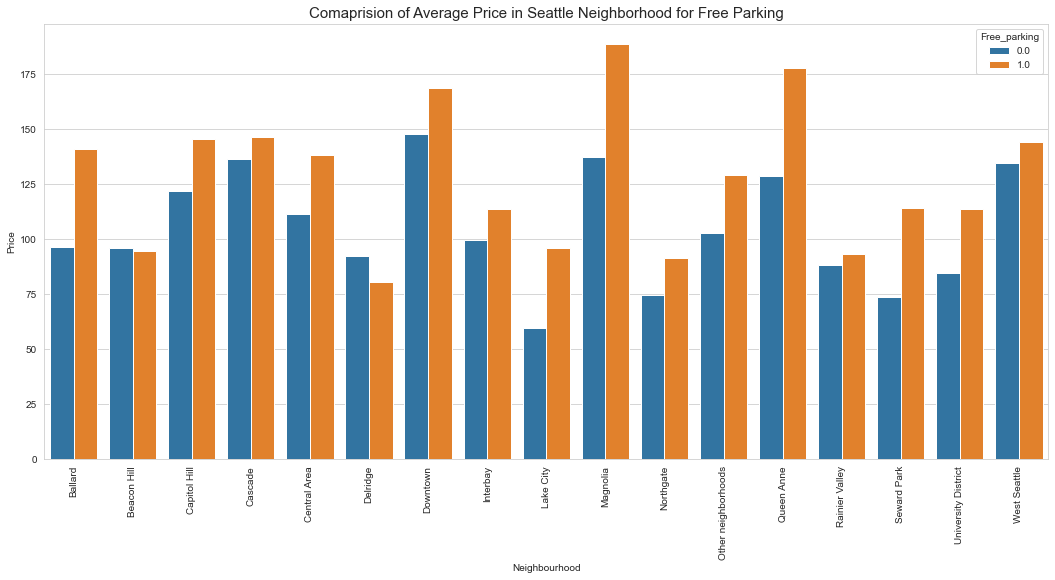

In [219]:
price_df = listings_clean.groupby(['neighbourhood_group_cleansed','Free_parking']).price.mean().reset_index()
plt.figure(figsize=(18,8))
sns.barplot(x="neighbourhood_group_cleansed", y="price",hue="Free_parking", data=price_df)
plt.xlabel("Neighbourhood",fontsize=10)
plt.ylabel("Price",fontsize=10)
plt.xticks(rotation=90)
plt.title('Comaprision of Average Price in Seattle Neighborhood for Free Parking', fontsize=15);

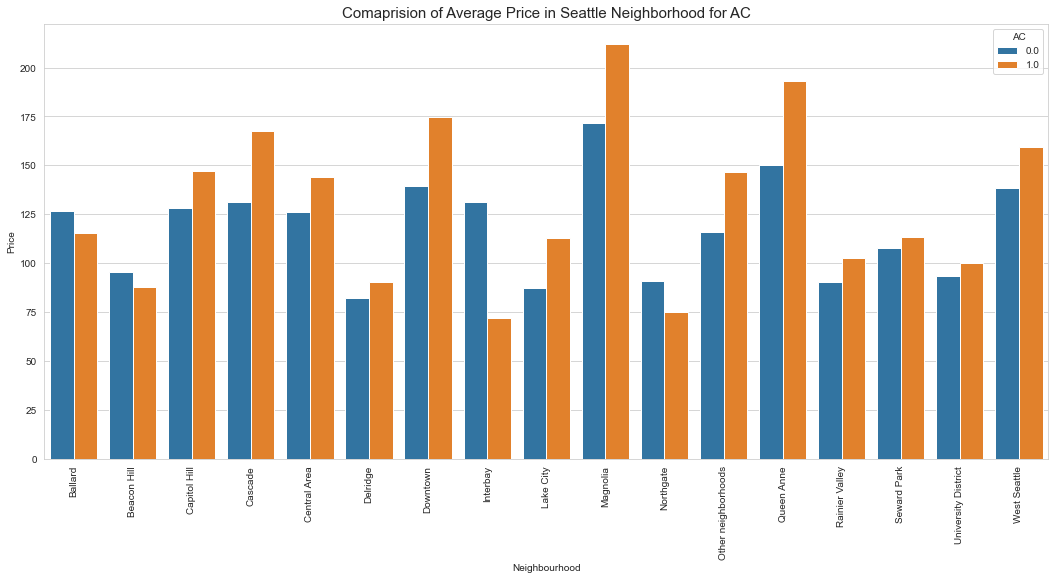

In [217]:
price_df = listings_clean.groupby(['neighbourhood_group_cleansed','AC']).price.mean().reset_index()
plt.figure(figsize=(18,8))
sns.barplot(x="neighbourhood_group_cleansed", y="price",hue="AC", data=price_df)
plt.xlabel("Neighbourhood",fontsize=10)
plt.ylabel("Price",fontsize=10)
plt.xticks(rotation=90)
plt.title('Comaprision of Average Price in Seattle Neighborhood for AC', fontsize=15);

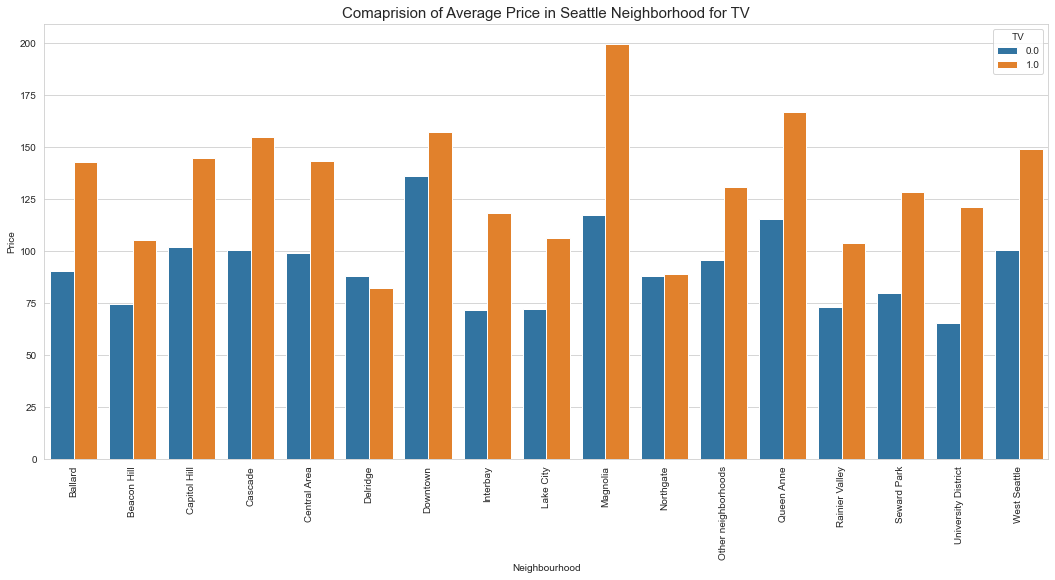

In [216]:
price_df = listings_clean.groupby(['neighbourhood_group_cleansed','TV']).price.mean().reset_index()
plt.figure(figsize=(18,8))
sns.barplot(x="neighbourhood_group_cleansed", y="price",hue="TV", data=price_df)
plt.xlabel("Neighbourhood",fontsize=10)
plt.ylabel("Price",fontsize=10)
plt.xticks(rotation=90)
plt.title('Comaprision of Average Price in Seattle Neighborhood for TV', fontsize=15);

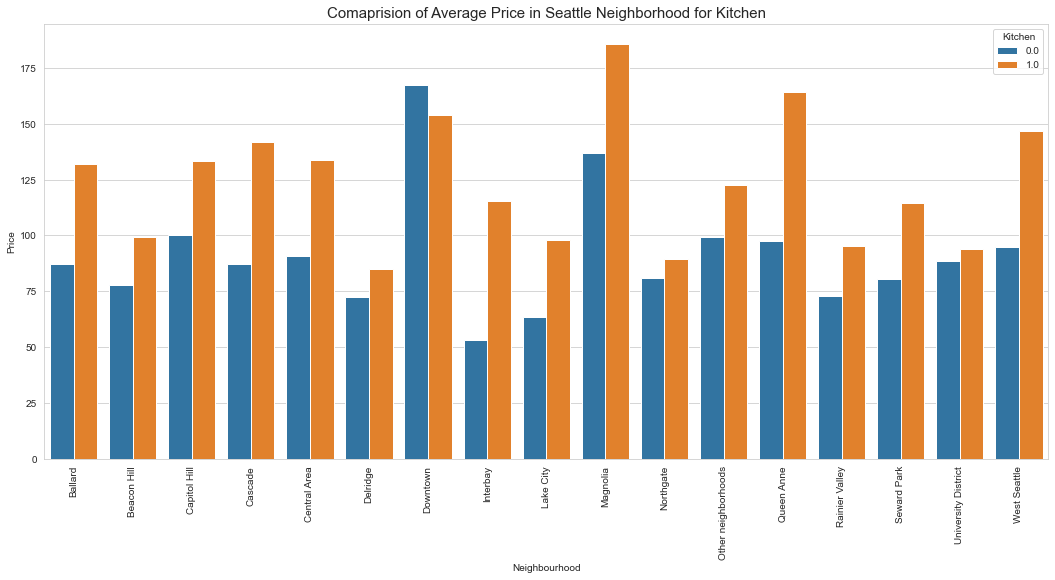

In [215]:
price_df = listings_clean.groupby(['neighbourhood_group_cleansed','Kitchen']).price.mean().reset_index()
plt.figure(figsize=(18,8))
sns.barplot(x="neighbourhood_group_cleansed", y="price",hue="Kitchen", data=price_df)
plt.xlabel("Neighbourhood",fontsize=10)
plt.ylabel("Price",fontsize=10)
plt.xticks(rotation=90)
plt.title('Comaprision of Average Price in Seattle Neighborhood for Kitchen', fontsize=15);

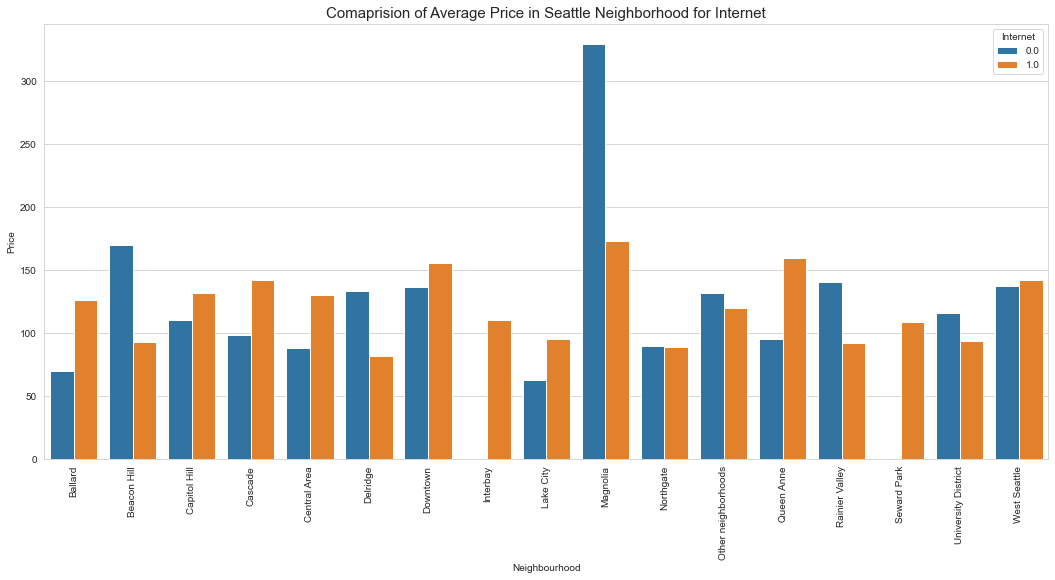

In [214]:
price_df = listings_clean.groupby(['neighbourhood_group_cleansed','Internet']).price.mean().reset_index()
plt.figure(figsize=(18,8))
sns.barplot(x="neighbourhood_group_cleansed", y="price",hue="Internet", data=price_df)
plt.xlabel("Neighbourhood",fontsize=10)
plt.ylabel("Price",fontsize=10)
plt.xticks(rotation=90)
plt.title('Comaprision of Average Price in Seattle Neighborhood for Internet', fontsize=15);

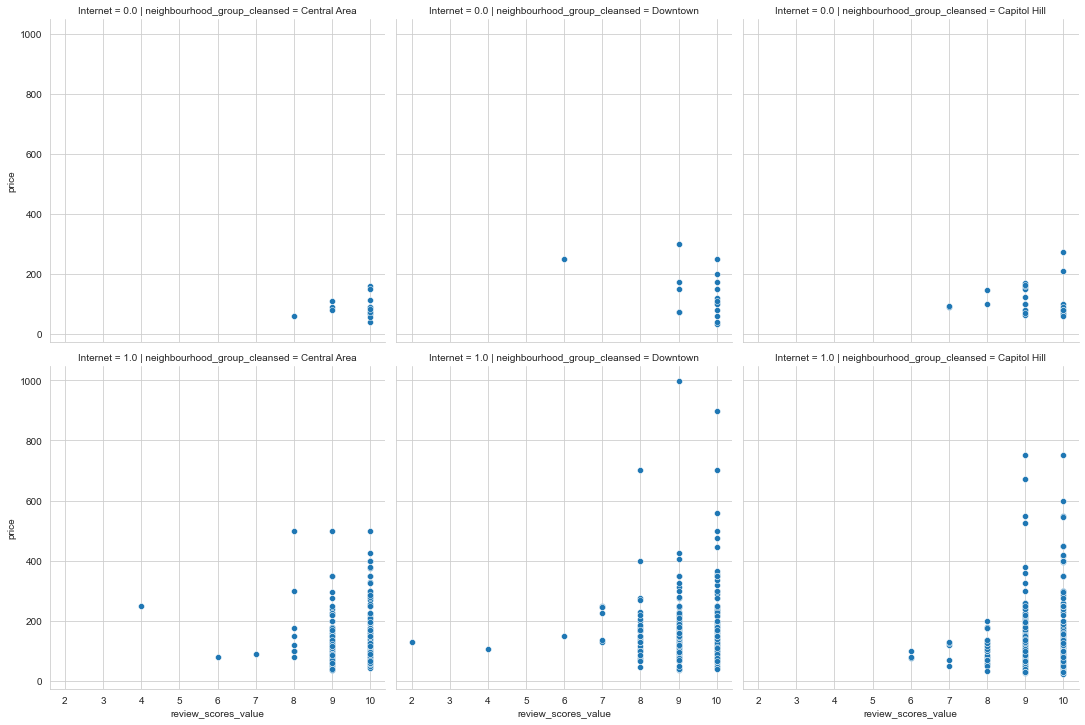

In [169]:
sns.relplot(
    data=top_4_df, x="review_scores_value", y="price",
    col="neighbourhood_group_cleansed",row = "Internet",
    kind="scatter"
);

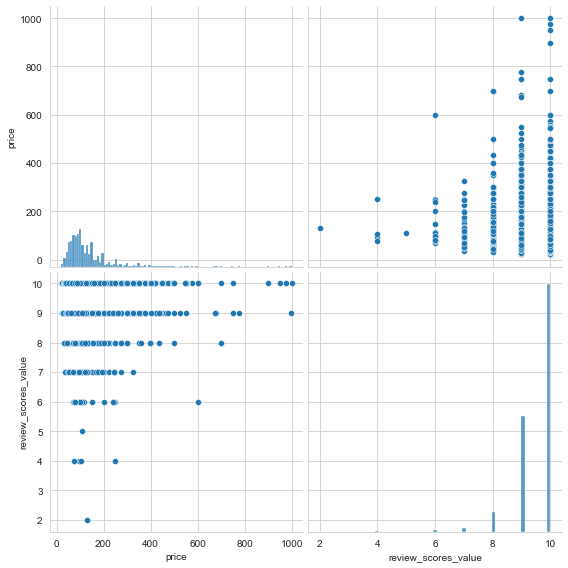

In [210]:
sns.pairplot(listings_clean[['price','review_scores_value']],diag_kind='hist',size=4)


In [211]:
neigh_group_amenities = listings_clean.groupby('neighbourhood_group_cleansed').aggregate({'Internet':'sum','Heating':'sum','Kitchen':'sum','Gas_detector':'sum','Essentials':'sum','Washer_dryer':'sum','TV':'sum','AC':'sum','Free_parking':'sum','neighbourhood_cleansed':'count'})
neigh_group_amenities.columns = ['Internet','Heating','Kitchen','Gas_detector','Essentials','Washer_dryer','TV','AC','Free_parking','num_of_listings']
neigh_group_amenities.reset_index()

,neighbourhood_group_cleansed,Internet,Heating,Kitchen,Gas_detector,Essentials,Washer_dryer,TV,AC,Free_parking,num_of_listings
0,Ballard,224.0,221.0,193.0,201.0,193.0,176.0,152.0,37.0,146.0,230
1,Beacon Hill,115.0,111.0,93.0,100.0,84.0,96.0,78.0,12.0,97.0,118
2,Capitol Hill,538.0,533.0,520.0,465.0,469.0,452.0,381.0,74.0,207.0,567
3,Cascade,86.0,83.0,86.0,70.0,75.0,75.0,65.0,22.0,34.0,89
4,Central Area,353.0,345.0,323.0,325.0,316.0,304.0,247.0,47.0,233.0,369
5,Delridge,76.0,75.0,69.0,73.0,70.0,64.0,62.0,10.0,61.0,79
6,Downtown,512.0,498.0,515.0,457.0,474.0,487.0,459.0,226.0,166.0,530
7,Interbay,11.0,11.0,10.0,10.0,11.0,9.0,9.0,4.0,8.0,11
8,Lake City,63.0,65.0,57.0,56.0,50.0,55.0,41.0,14.0,61.0,67
9,Magnolia,59.0,58.0,51.0,52.0,47.0,52.0,45.0,9.0,48.0,61


In [212]:
#Convert Count to Percentage
neigh_group_amenities_2 = neigh_group_amenities
ameities_columns = ['Internet','Heating','Kitchen','Gas_detector','Essentials','Washer_dryer','TV','AC','Free_parking']
for col in ameities_columns:
    neigh_group_amenities_2[col] = (neigh_group_amenities_2[col]/neigh_group_amenities_2['num_of_listings'])*100
#neigh_group_amenities_2.drop('num_of_listings',axis=1, inplace = True)
neigh_group_amenities_2

,Internet,Heating,Kitchen,Gas_detector,Essentials,Washer_dryer,TV,AC,Free_parking,num_of_listings
neighbourhood_group_cleansed,,,,,,,,,,
Ballard,97.391304,96.086957,83.913043,87.391304,83.913043,76.521739,66.086957,16.086957,63.478261,230
Beacon Hill,97.457627,94.067797,78.813559,84.745763,71.186441,81.355932,66.101695,10.169492,82.203390,118
Capitol Hill,94.885362,94.003527,91.710758,82.010582,82.716049,79.717813,67.195767,13.051146,36.507937,567
Cascade,96.629213,93.258427,96.629213,78.651685,84.269663,84.269663,73.033708,24.719101,38.202247,89
Central Area,95.663957,93.495935,87.533875,88.075881,85.636856,82.384824,66.937669,12.737127,63.143631,369
Delridge,96.202532,94.936709,87.341772,92.405063,88.607595,81.012658,78.481013,12.658228,77.215190,79
Downtown,96.603774,93.962264,97.169811,86.226415,89.433962,91.886792,86.603774,42.641509,31.320755,530
Interbay,100.000000,100.000000,90.909091,90.909091,100.000000,81.818182,81.818182,36.363636,72.727273,11
Lake City,94.029851,97.014925,85.074627,83.582090,74.626866,82.089552,61.194030,20.895522,91.044776,67


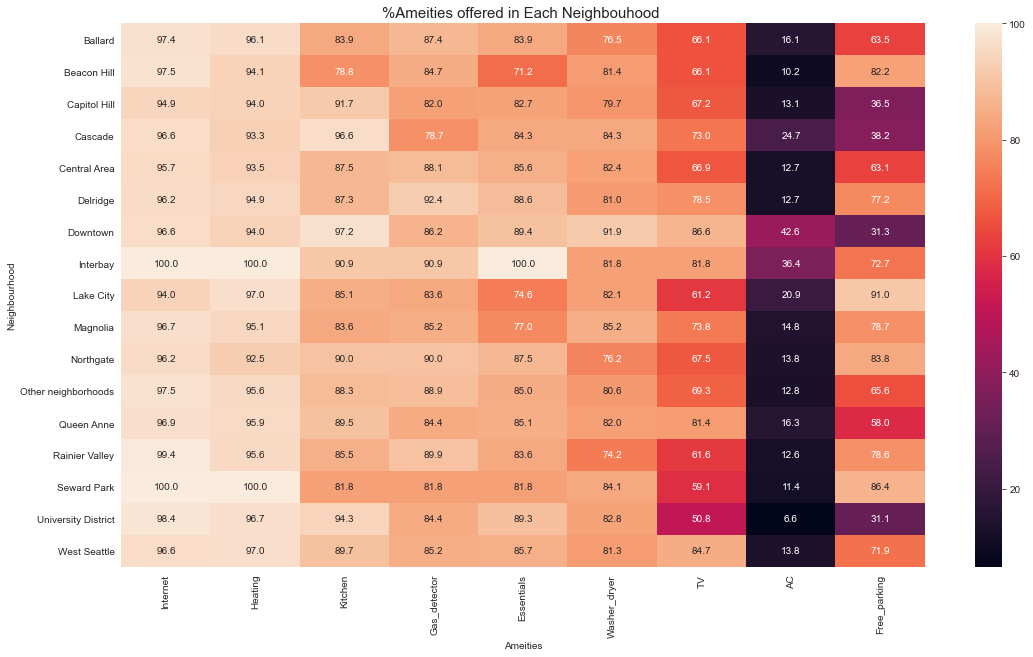

In [213]:
sns.heatmap(data=neigh_group_amenities_2[ameities_columns], annot=True, fmt='.1f');
plt.ylabel("Neighbourhood",fontsize=10)
plt.xlabel("Ameities",fontsize=10)
plt.xticks(rotation=90)
plt.title('%Ameities offered in Each Neighbouhood ', fontsize=15);

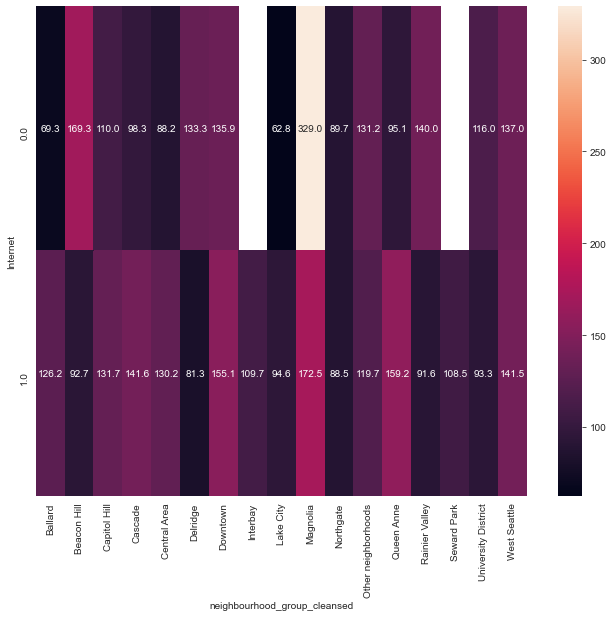

In [200]:
df_m = listings_clean.groupby(['neighbourhood_group_cleansed','Internet']).price.mean()
df_m = df_m.unstack(level= 0)
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_m, annot=True, fmt='.1f')
plt.show()

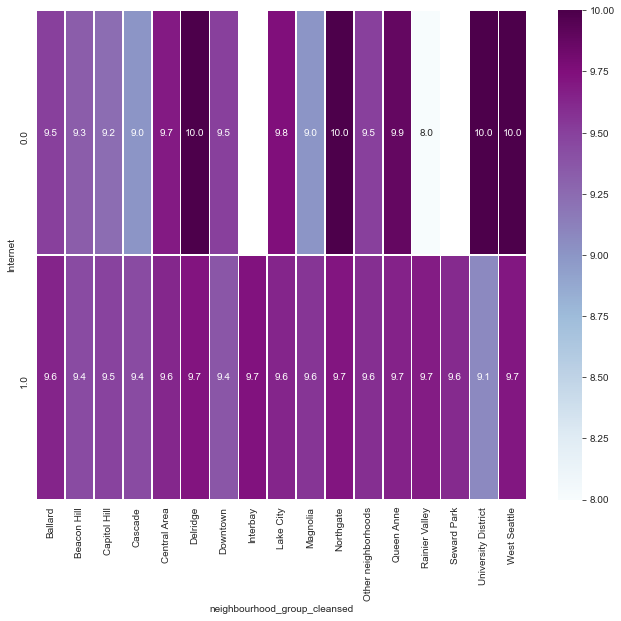

In [207]:
df_m = listings_clean.groupby(['neighbourhood_group_cleansed','Internet']).review_scores_value.mean()
df_m = df_m.unstack(level= 0)
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_m, annot=True,fmt=".1f", cmap="BuPu", linewidths=.6)
plt.show()

In [142]:
review_cols = [col for col in listings_clean.columns if 'review' in col]
review_cols

['number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'first_review_day',
 'first_review_day_name',
 'first_review_dayofweek',
 'first_review_IsWeekend',
 'first_review_month',
 'first_review_month_name',
 'first_review_month_year',
 'first_review_quarter',
 'first_review_quarter_year',
 'first_review_year',
 'last_review_day',
 'last_review_day_name',
 'last_review_dayofweek',
 'last_review_IsWeekend',
 'last_review_month',
 'last_review_month_name',
 'last_review_month_year',
 'last_review_quarter',
 'last_review_quarter_year',
 'last_review_year']